In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from matplotlib.patches import Rectangle

### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','init_depth']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        data_sec = datafile[var]
        dict_var[var] = data_sec[idx]
        
    
    return dict_var       

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axn.add_collection(pc)
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [3]:
# def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
#     latgridf = latgridi-1
#     fmask = mesh.fmask[0, :, latgridf]
#     tmask = mesh.tmask[0]
    
#     lons = data.init_lon[(data.final_section != 0)]
    
#     f_lons = mesh.glamf[0, latgridf]
#     u_lons = mesh.glamv[0, latgridf]
#     w_depths = mesh.gdepw_1d

#     m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
#     cmap = cm.deep
    
#     arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
#                               density=True,vmax=vmax
#                                 )
    
#     X,Y = np.meshgrid(xe,ye)
    
#     im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
#     axv.invert_yaxis()
#     axv.set_title(title)
#     axv.set_xlabel('Longitude (°E)')
#     axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
#     axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
#     axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
#     axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
#     pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
#     axv.add_collection(pc)

#     if cblabel == True:
#         cb = fig.colorbar(im,ax=axv)
#         cb.set_label('Transport (m/s)')
    
#     if ylabel == True:
#         axv.set_ylabel('Depth (m)')
        
#     else: 
#         axv.set_yticklabels([])

In [4]:
#TODO: Rename this function (in all files)
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel,NW=False):
    
    if NW == True:
        latgridf = latgridi-1 #actually lon
        fmask = mesh.fmask[0,:,:,latgridf] # Giving mask of longitudes
        tmask = mesh.tmask[0]
        
        lons = data.init_lat[(data.final_section != 0)]
        
        f_lons = mesh.gphif[0,:, latgridf]
        u_lons = mesh.gphiv[0,:, latgridf]
        w_depths = mesh.gdepw_1d
    else:
        latgridf = latgridi-1
        fmask = mesh.fmask[0, :, latgridf]
        tmask = mesh.tmask[0]
            
        lons = data.init_lon[(data.final_section != 0)]
            
        f_lons = mesh.glamf[0, latgridf]
        u_lons = mesh.glamv[0, latgridf]
        w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    try:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    except:
        im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time),cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Latitude (°W)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

### Import data

In [6]:
##Forwards - Eastern JdF
#Jan
datafas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
datafrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

#July
datafas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
databvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backADM_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

#July
databvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backadm_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

##Forwards - SJGI
# Jan
datafg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
datafg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
# Jan
databg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jan18/back_straight_01jan18_s7t21_check/ariane_positions_quantitative.nc')
databg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
databg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jul18/back_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
databsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

data_dict = {'datafvs':data,'datafas':datafas,'datafds':datafds,'datafrsvs':datafrsvs,'datafsjvs':datafsjvs,'datafhsvs':datafhsvs,
             'datafvs07':datafvs07,'datafas07':datafas07,'datafds07':datafds07,'datafrsvs07':datafrsvs07,'datafsjvs07':datafsjvs07,'datafhsvs07':datafhsvs07,
             'databvs':databvs,'databas':databas,'databds':databds,'databrsvs':databrsvs,'databsjvs':databsjvs,'databhsvs':databhsvs,
             'databvs07':databvs07,'databas07':databas07,'databds07':databds07,'databrsvs07':databrsvs07,'databsjvs07':databsjvs07,'databhsvs07':databhsvs07,
             'datafpr':datafpr,'datafg1':datafg1,'datafg2':datafg2,'datafrspr':datafrspr,'datafsjpr':datafsjpr,'datafhspr':datafhspr,
             'datafpr07':datafpr07,'datafg107':datafg107,'datafg207':datafg207,'datafrspr07':datafrspr07,'datafsjpr07':datafsjpr07,'datafhspr07':datafhspr07,
             'databpr':databpr,'databg1':databg1,'databg2':databg2,'databrspr':databrspr,'databsjpr':databsjpr,'databhspr':databhspr,
             'databpr07':databpr07,'databg107':databg107,'databg207':databg207,'databrspr07':databrspr07,'databsjpr07':databsjpr07,'databhspr07':databhspr07
}

### Section plots

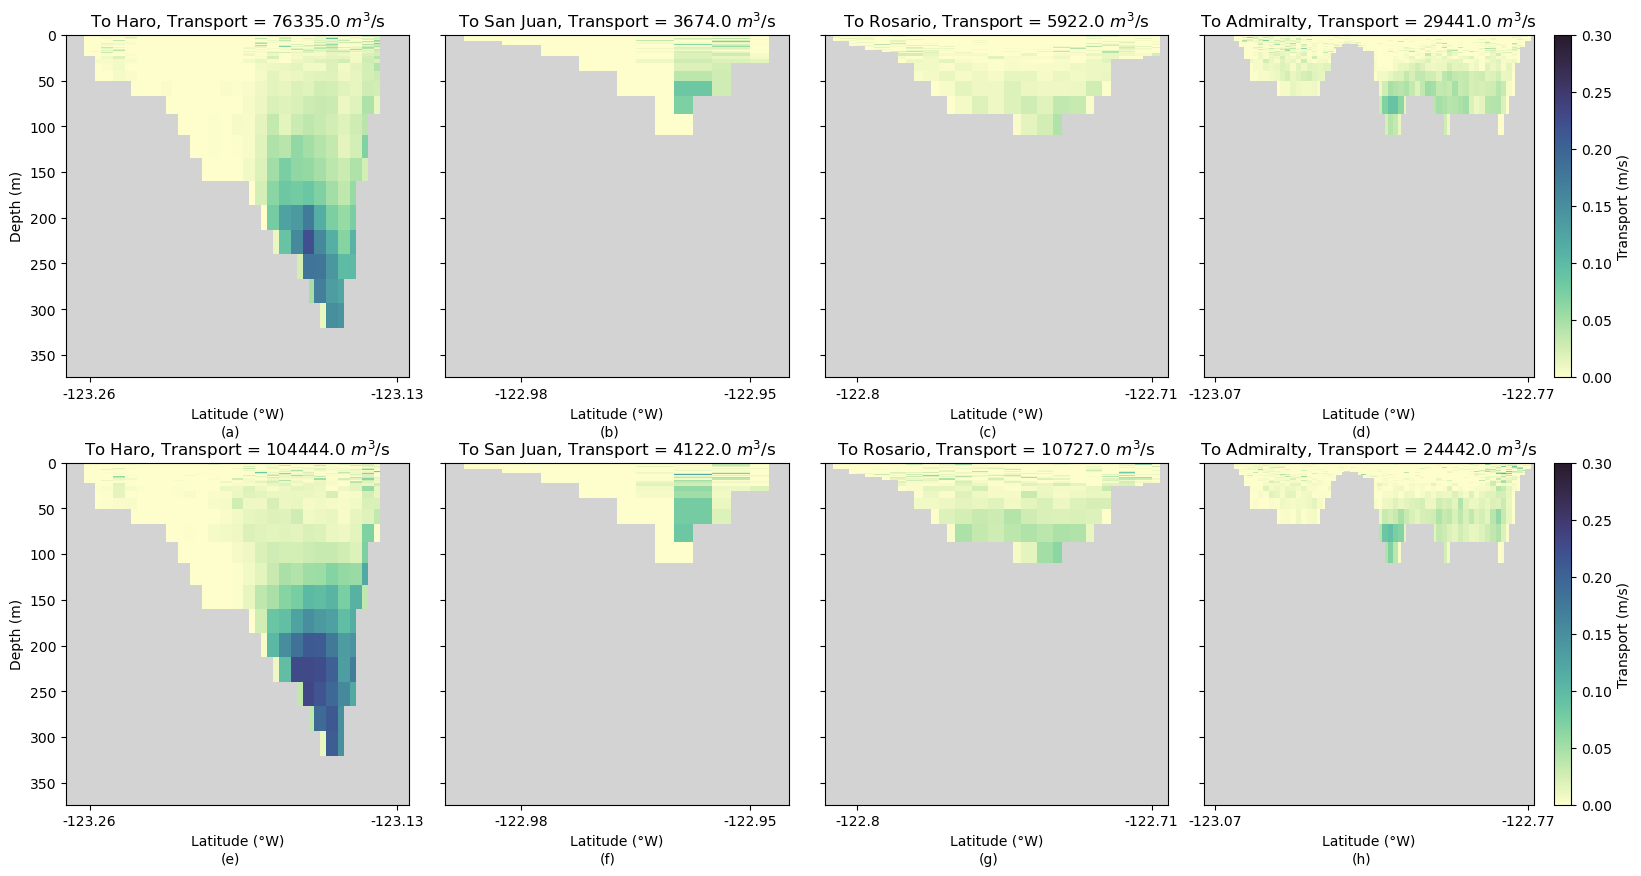

In [7]:
#VicSill to Haro
harofvs = get_secdata(data_dict['datafvs'],6)
rosfvs = get_secdata(data_dict['datafvs'],4)
admfvs = get_secdata(data_dict['datafvs'],2)
sjcfvs = get_secdata(data_dict['datafvs'],5)

#In summer
harofvs_jul = get_secdata(data_dict['datafvs07'],6)
rosfvs_jul = get_secdata(data_dict['datafvs07'],4)
admfvs_jul = get_secdata(data_dict['datafvs07'],2)
sjcfvs_jul = get_secdata(data_dict['datafvs07'],5)

lonWharo = 215
lonEharo = 245
latharo = 300
lonWros=283
lonEros=305
latros = 267
latsjc = 282
lonWsjc = 258
lonEsjc = 268
lonWadm = 200
lonEadm = 262
latadm = 218
lonWg1 = 235
lonEg1 = 253
latg1 = 386

section_transp = []
section_transp_jul = []
sectionnum = [0,2,3,4,5,6]
starttime = 1
endtime = 168

for section in sectionnum:
    section_transp.append(get_datat(data_dict['datafvs'],section,starttime,endtime))
    section_transp_jul.append(get_datat(data_dict['datafvs07'],section,starttime,endtime))


title = f'To Haro, Transport = {np.round(section_transp[5],0)} $m^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transp[4],0)} $m^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transp[3],0)} $m^3$/s'
title4 = f'To Admiralty, Transport = {np.round(section_transp[1],0)} $m^3$/s'
time = 168

smin = 28
smax = 33

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,harofvs['final_lon'],harofvs['final_z'],harofvs['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax3,rosfvs['final_lon'],rosfvs['final_z'],rosfvs['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax4,admfvs['final_lon'],admfvs['final_z'],admfvs['final_transp'],lonWadm,lonEadm,latadm,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f'To Haro, Transport = {np.round(section_transp_jul[5],0)} $m^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transp_jul[4],0)} $m^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transp_jul[3],0)} $m^3$/s'
title4 = f'To Admiralty, Transport = {np.round(section_transp_jul[1],0)} $m^3$/s'

plotCS(ax5,harofvs_jul['final_lon'],harofvs_jul['final_z'],harofvs_jul['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax6,sjcfvs_jul['final_lon'],sjcfvs_jul['final_z'],sjcfvs_jul['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax7,rosfvs_jul['final_lon'],rosfvs_jul['final_z'],rosfvs_jul['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax8,admfvs_jul['final_lon'],admfvs_jul['final_z'],admfvs_jul['final_transp'],lonWadm,lonEadm,latadm,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/forwardVS_section.png',bbox_inches='tight')


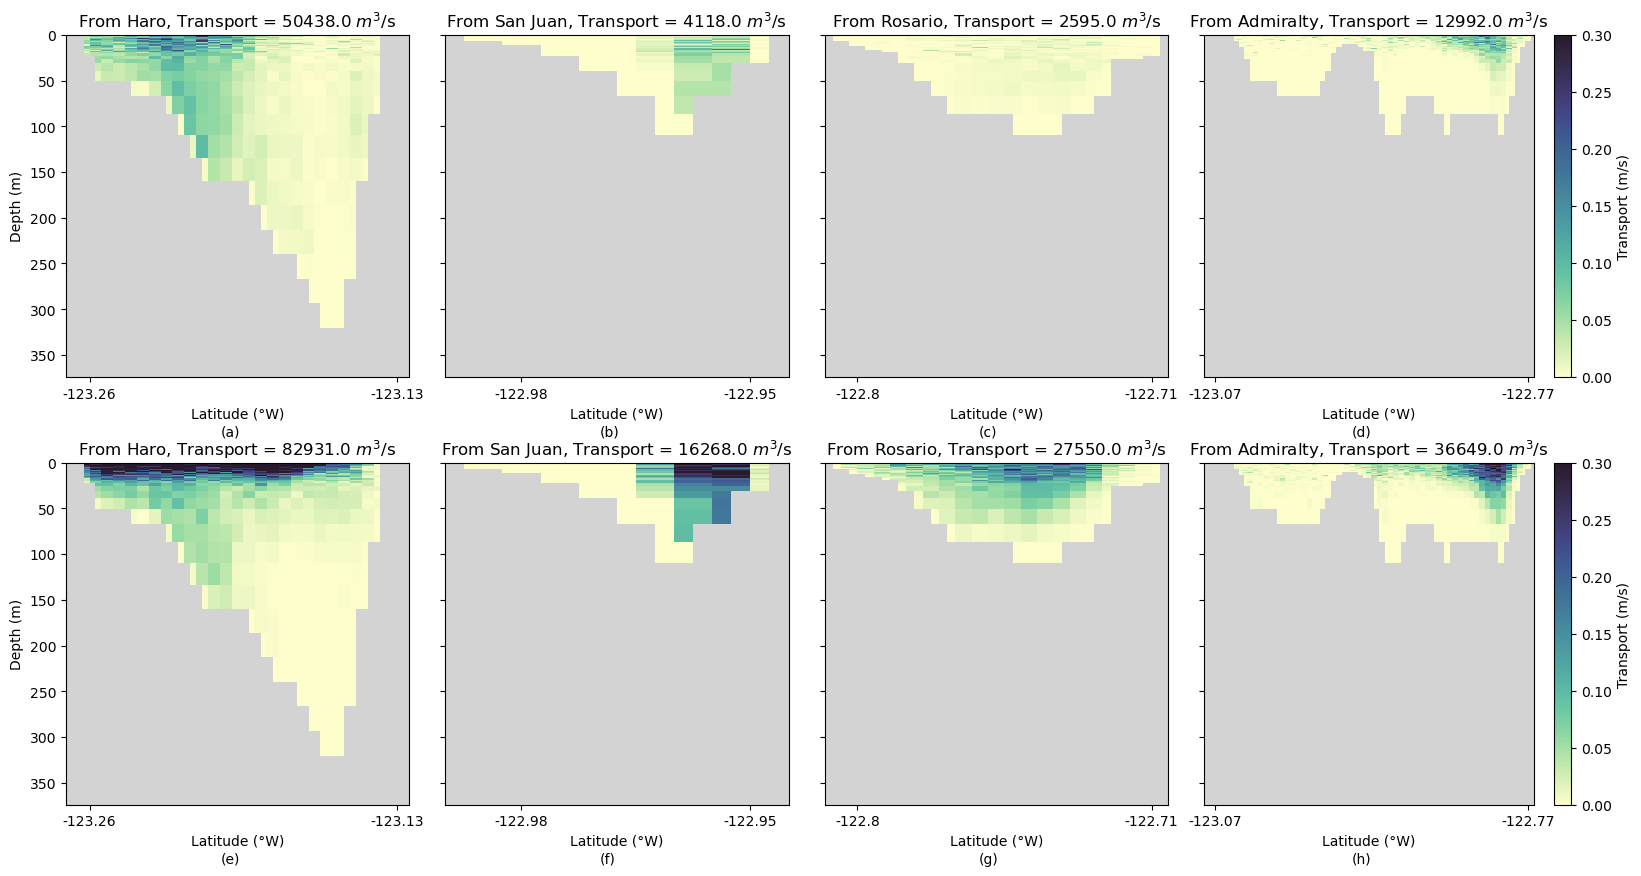

In [8]:
#VicSill to Haro
harobvs = get_secdata(data_dict['databvs'],6)
rosbvs = get_secdata(data_dict['databvs'],4)
admbvs = get_secdata(data_dict['databvs'],2)
sjcbvs = get_secdata(data_dict['databvs'],5)

#In summer
harobvs_jul = get_secdata(data_dict['databvs07'],6)
rosbvs_jul = get_secdata(data_dict['databvs07'],4)
admbvs_jul = get_secdata(data_dict['databvs07'],2)
sjcbvs_jul = get_secdata(data_dict['databvs07'],5)

section_transpbvs = []
section_transpbvs_jul = []

for section in sectionnum:
    section_transpbvs.append(get_datat(data_dict['databvs'],section,starttime,endtime))
    section_transpbvs_jul.append(get_datat(data_dict['databvs07'],section,starttime,endtime))


title = f'From Haro, Transport = {np.round(section_transpbvs[5],0)} $m^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transpbvs[4],0)} $m^3$/s'
title3 = f'From Rosario, Transport = {np.round(section_transpbvs[3],0)} $m^3$/s'
title4 = f'From Admiralty, Transport = {np.round(section_transpbvs[1],0)} $m^3$/s'
time = 168

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,harobvs['final_lon'],harobvs['final_z'],harobvs['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax2,sjcbvs['final_lon'],sjcbvs['final_z'],sjcbvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax3,rosbvs['final_lon'],rosbvs['final_z'],rosbvs['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax4,admbvs['final_lon'],admbvs['final_z'],admbvs['final_transp'],lonWadm,lonEadm,latadm,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f'From Haro, Transport = {np.round(section_transpbvs_jul[5],0)} $m^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transpbvs_jul[4],0)} $m^3$/s'
title3 = f'From Rosario, Transport = {np.round(section_transpbvs_jul[3],0)} $m^3$/s'
title4 = f'From Admiralty, Transport = {np.round(section_transpbvs_jul[1],0)} $m^3$/s'

plotCS(ax5,harobvs_jul['final_lon'],harobvs_jul['final_z'],harobvs_jul['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax6,sjcbvs_jul['final_lon'],sjcbvs_jul['final_z'],sjcbvs_jul['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax7,rosbvs_jul['final_lon'],rosbvs_jul['final_z'],rosbvs_jul['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax8,admbvs_jul['final_lon'],admbvs_jul['final_z'],admbvs_jul['final_transp'],lonWadm,lonEadm,latadm,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/backwardVS_section.png',bbox_inches='tight')

Where is water on the west side of SJC coming from / going to??

### Point Roberts seeding

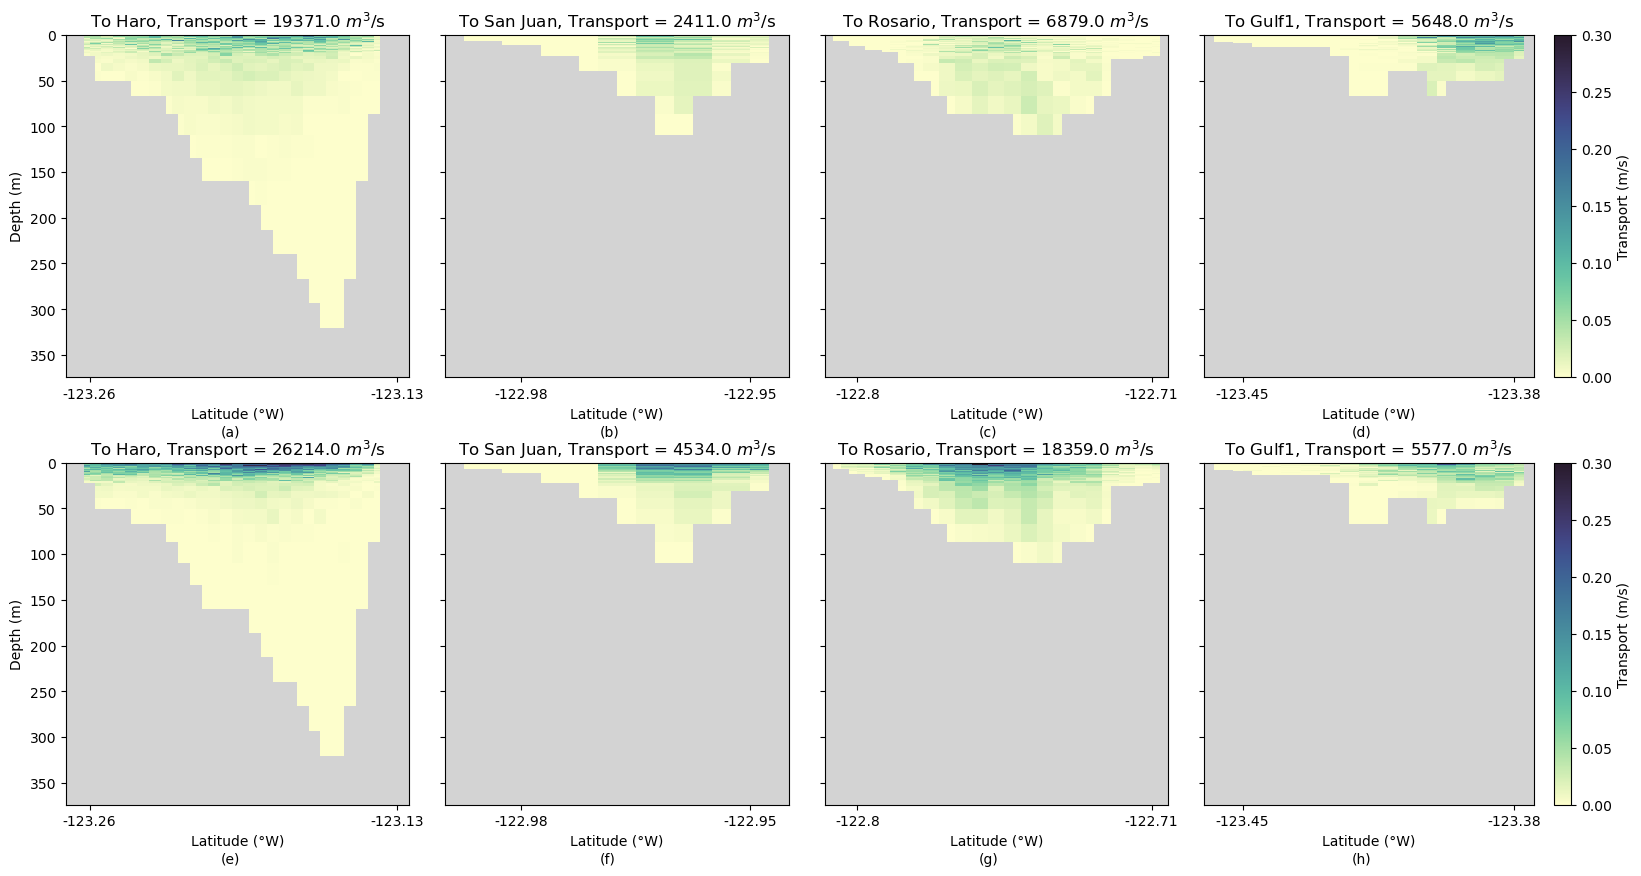

In [9]:
#VicSill to Haro
harofpr = get_secdata(data_dict['datafpr'],6)
rosfpr = get_secdata(data_dict['datafpr'],4)
g1fpr = get_secdata(data_dict['datafpr'],2)
sjcfpr = get_secdata(data_dict['datafpr'],5)

#In summer
harofpr_jul = get_secdata(data_dict['datafpr07'],6)
rosfpr_jul = get_secdata(data_dict['datafpr07'],4)
g1fpr_jul = get_secdata(data_dict['datafpr07'],2)
sjcfpr_jul = get_secdata(data_dict['datafpr07'],5)

section_transp_pr = []
section_transp_pr_jul = []
sectionnum = [0,2,3,4,5,6]
starttime = 1
endtime = 168

for section in sectionnum:
    section_transp_pr.append(get_datat(data_dict['datafpr'],section,starttime,endtime))
    section_transp_pr_jul.append(get_datat(data_dict['datafpr07'],section,starttime,endtime))


title = f'To Haro, Transport = {np.round(section_transp_pr[5],0)} $m^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transp_pr[4],0)} $m^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transp_pr[3],0)} $m^3$/s'
title4 = f'To Gulf1, Transport = {np.round(section_transp_pr[1],0)} $m^3$/s'
time = 168

smin = 28
smax = 33

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,harofpr['final_lon'],harofpr['final_z'],harofpr['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax2,sjcfpr['final_lon'],sjcfpr['final_z'],sjcfpr['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax3,rosfpr['final_lon'],rosfpr['final_z'],rosfpr['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax4,g1fpr['final_lon'],g1fpr['final_z'],g1fpr['final_transp'],lonWg1,lonEg1,latg1,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f'To Haro, Transport = {np.round(section_transp_pr_jul[5],0)} $m^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transp_pr_jul[4],0)} $m^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transp_pr_jul[3],0)} $m^3$/s'
title4 = f'To Gulf1, Transport = {np.round(section_transp_pr_jul[1],0)} $m^3$/s'

plotCS(ax5,harofpr_jul['final_lon'],harofpr_jul['final_z'],harofpr_jul['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax6,sjcfpr_jul['final_lon'],sjcfpr_jul['final_z'],sjcfpr_jul['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax7,rosfpr_jul['final_lon'],rosfpr_jul['final_z'],rosfpr_jul['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax8,g1fpr_jul['final_lon'],g1fpr_jul['final_z'],g1fpr_jul['final_transp'],lonWg1,lonEg1,latg1,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/forwardPR_section.png',bbox_inches='tight')


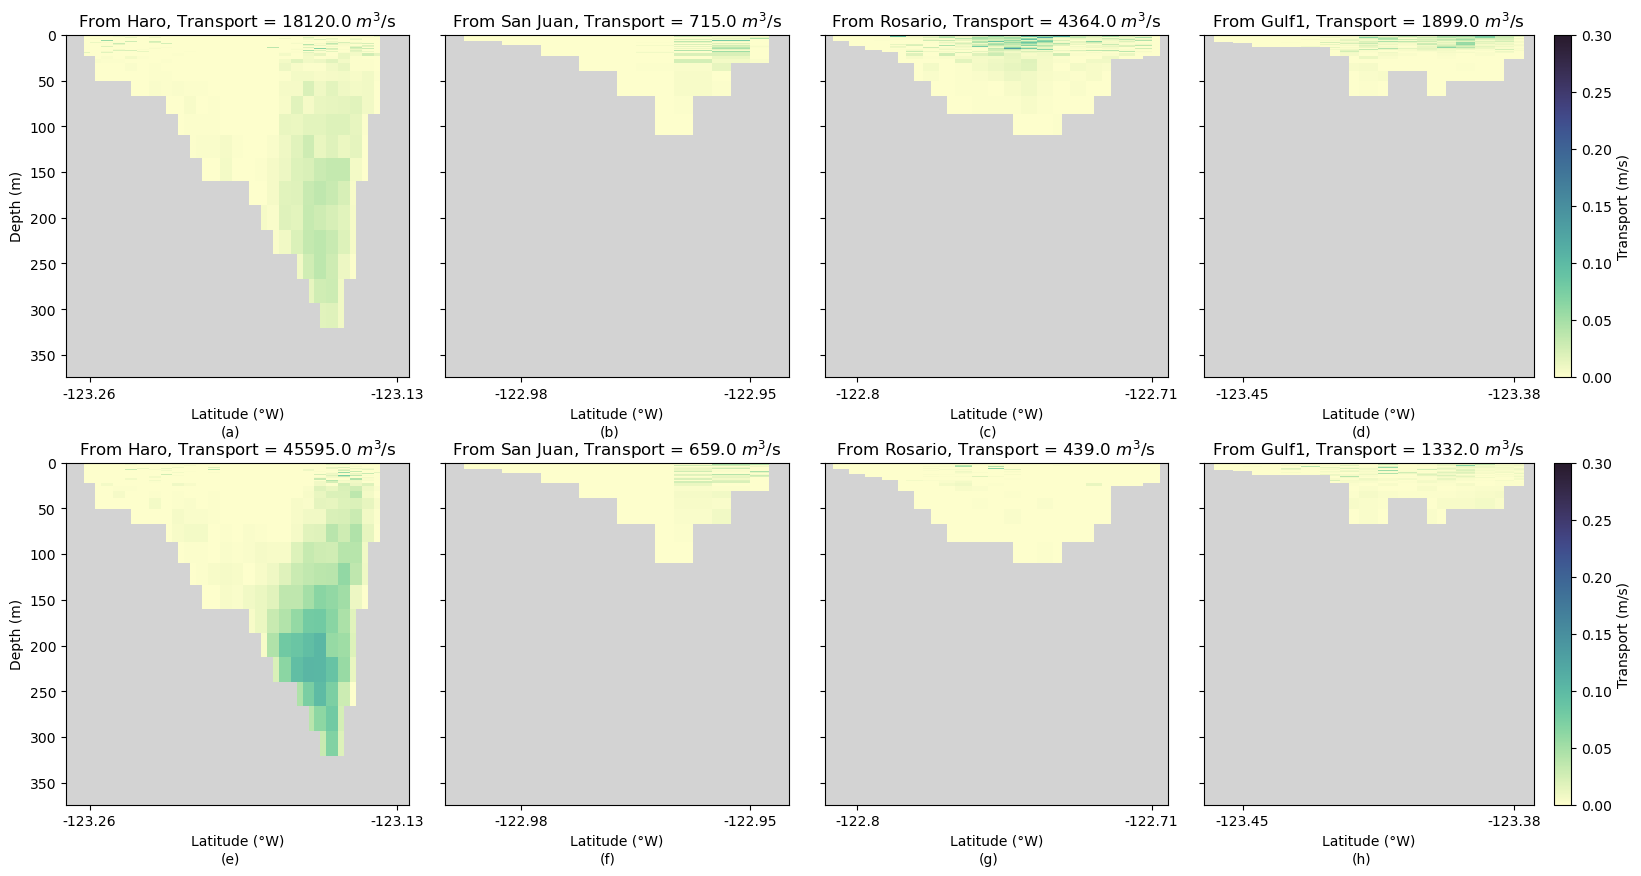

In [10]:
#VicSill to Haro
harobpr = get_secdata(data_dict['databpr'],6)
rosbpr = get_secdata(data_dict['databpr'],4)
g1bpr = get_secdata(data_dict['databpr'],2)
sjcbpr = get_secdata(data_dict['databpr'],5)

#In summer
harobpr_jul = get_secdata(data_dict['databpr07'],6)
rosbpr_jul = get_secdata(data_dict['databpr07'],4)
g1bpr_jul = get_secdata(data_dict['databpr07'],2)
sjcbpr_jul = get_secdata(data_dict['databpr07'],5)

section_transp_bpr = []
section_transp_bpr_jul = []
sectionnum = [0,2,3,4,5,6]
starttime = 1
endtime = 168

for section in sectionnum:
    section_transp_bpr.append(get_datat(data_dict['databpr'],section,starttime,endtime))
    section_transp_bpr_jul.append(get_datat(data_dict['databpr07'],section,starttime,endtime))


title = f'From Haro, Transport = {np.round(section_transp_bpr[5],0)} $m^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transp_bpr[4],0)} $m^3$/s'
title3 = f'From Rosario, Transport = {np.round(section_transp_bpr[3],0)} $m^3$/s'
title4 = f'From Gulf1, Transport = {np.round(section_transp_bpr[1],0)} $m^3$/s'
time = 168

smin = 28
smax = 33

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,harobpr['final_lon'],harobpr['final_z'],harobpr['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax2,sjcbpr['final_lon'],sjcbpr['final_z'],sjcbpr['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax3,rosbpr['final_lon'],rosbpr['final_z'],rosbpr['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax4,g1bpr['final_lon'],g1bpr['final_z'],g1bpr['final_transp'],lonWg1,lonEg1,latg1,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f'From Haro, Transport = {np.round(section_transp_bpr_jul[5],0)} $m^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transp_bpr_jul[4],0)} $m^3$/s'
title3 = f'From Rosario, Transport = {np.round(section_transp_bpr_jul[3],0)} $m^3$/s'
title4 = f'From Gulf1, Transport = {np.round(section_transp_bpr_jul[1],0)} $m^3$/s'

plotCS(ax5,harobpr_jul['final_lon'],harobpr_jul['final_z'],harobpr_jul['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax6,sjcbpr_jul['final_lon'],sjcbpr_jul['final_z'],sjcbpr_jul['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax7,rosbpr_jul['final_lon'],rosbpr_jul['final_z'],rosbpr_jul['final_transp'],lonWros,lonEros,latros,38,0.3,time,title3,False,False)
plotCS(ax8,g1bpr_jul['final_lon'],g1bpr_jul['final_z'],g1bpr_jul['final_transp'],lonWg1,lonEg1,latg1,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/backwardPR_section.png',bbox_inches='tight')


### Backwards rosario seeding

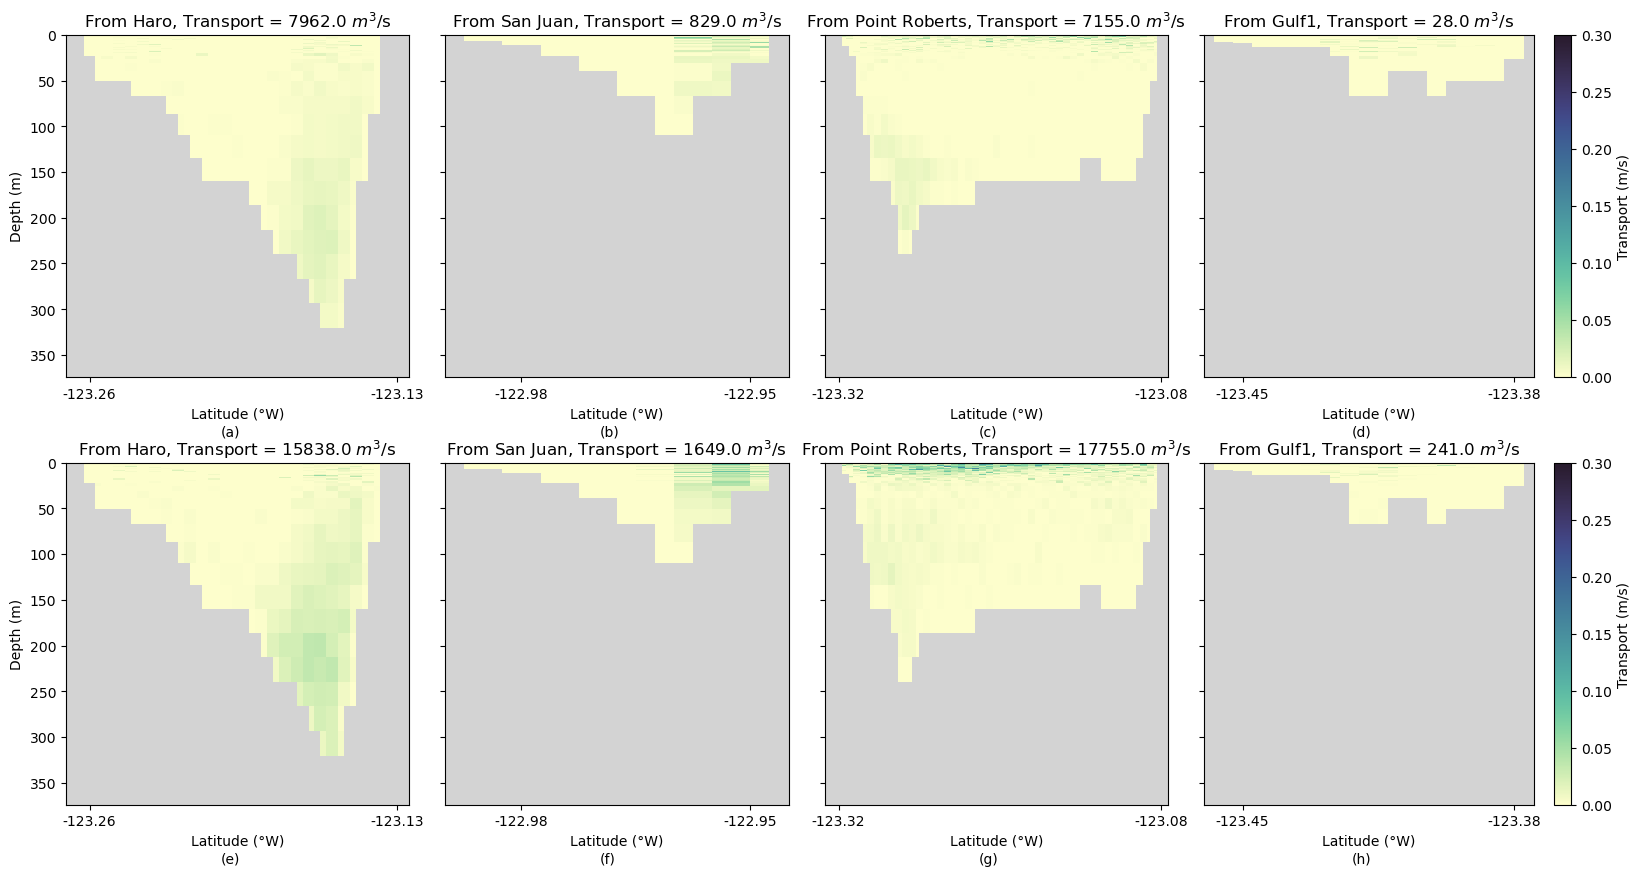

In [11]:
#VicSill to Haro
harobrspr = get_secdata(data_dict['databrspr'],6)
prbrspr = get_secdata(data_dict['databrspr'],2)
g1brspr = get_secdata(data_dict['databrspr'],3)
sjcbrspr = get_secdata(data_dict['databrspr'],5)

#In summer
harobrspr_jul = get_secdata(data_dict['databrspr07'],6)
prbrspr_jul = get_secdata(data_dict['databrspr07'],4)
g1brspr_jul = get_secdata(data_dict['databrspr07'],2)
sjcbrspr_jul = get_secdata(data_dict['databrspr07'],5)

section_transp_brspr = []
section_transp_brspr_jul = []
sectionnum = [0,2,3,4,5,6]
starttime = 1
endtime = 168

lonWpr = 260
lonEpr = 310
latpr = 386

for section in sectionnum:
    section_transp_brspr.append(get_datat(data_dict['databrspr'],section,starttime,endtime))
    section_transp_brspr_jul.append(get_datat(data_dict['databrspr07'],section,starttime,endtime))


title = f'From Haro, Transport = {np.round(section_transp_brspr[5],0)} $m^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transp_brspr[4],0)} $m^3$/s'
title3 = f'From Point Roberts, Transport = {np.round(section_transp_brspr[1],0)} $m^3$/s'
title4 = f'From Gulf1, Transport = {np.round(section_transp_brspr[3],0)} $m^3$/s'
time = 168

smin = 28
smax = 33

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,harobrspr['final_lon'],harobrspr['final_z'],harobrspr['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax2,sjcbrspr['final_lon'],sjcbrspr['final_z'],sjcbrspr['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax3,prbrspr['final_lon'],prbrspr['final_z'],prbrspr['final_transp'],lonWpr,lonEpr,latpr,38,0.3,time,title3,False,False)
plotCS(ax4,g1brspr['final_lon'],g1brspr['final_z'],g1brspr['final_transp'],lonWg1,lonEg1,latg1,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f'From Haro, Transport = {np.round(section_transp_brspr_jul[5],0)} $m^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transp_brspr_jul[4],0)} $m^3$/s'
title3 = f'From Point Roberts, Transport = {np.round(section_transp_brspr_jul[3],0)} $m^3$/s'
title4 = f'From Gulf1, Transport = {np.round(section_transp_brspr_jul[1],0)} $m^3$/s'

plotCS(ax5,harobrspr_jul['final_lon'],harobrspr_jul['final_z'],harobrspr_jul['final_transp'],lonWharo,lonEharo,latharo,38,0.3,time,title,False,True)
plotCS(ax6,sjcbrspr_jul['final_lon'],sjcbrspr_jul['final_z'],sjcbrspr_jul['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title2,False,False)
plotCS(ax7,prbrspr_jul['final_lon'],prbrspr_jul['final_z'],prbrspr_jul['final_transp'],lonWpr,lonEpr,latpr,38,0.3,time,title3,False,False)
plotCS(ax8,g1brspr_jul['final_lon'],g1brspr_jul['final_z'],g1brspr_jul['final_transp'],lonWg1,lonEg1,latg1,38,0.3,time,title4,True,False)
# plotCS2(ax2,sjcfvs['final_lon'],sjcfvs['final_z'],sjcfvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,time,title,True,True);

ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1, hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/backwardRSPR_section.png',bbox_inches='tight')


Show gulf1 to illustrate that there is not much transport? Not required if leaving the bar chart in

### Haro forward seeding (EJdF)

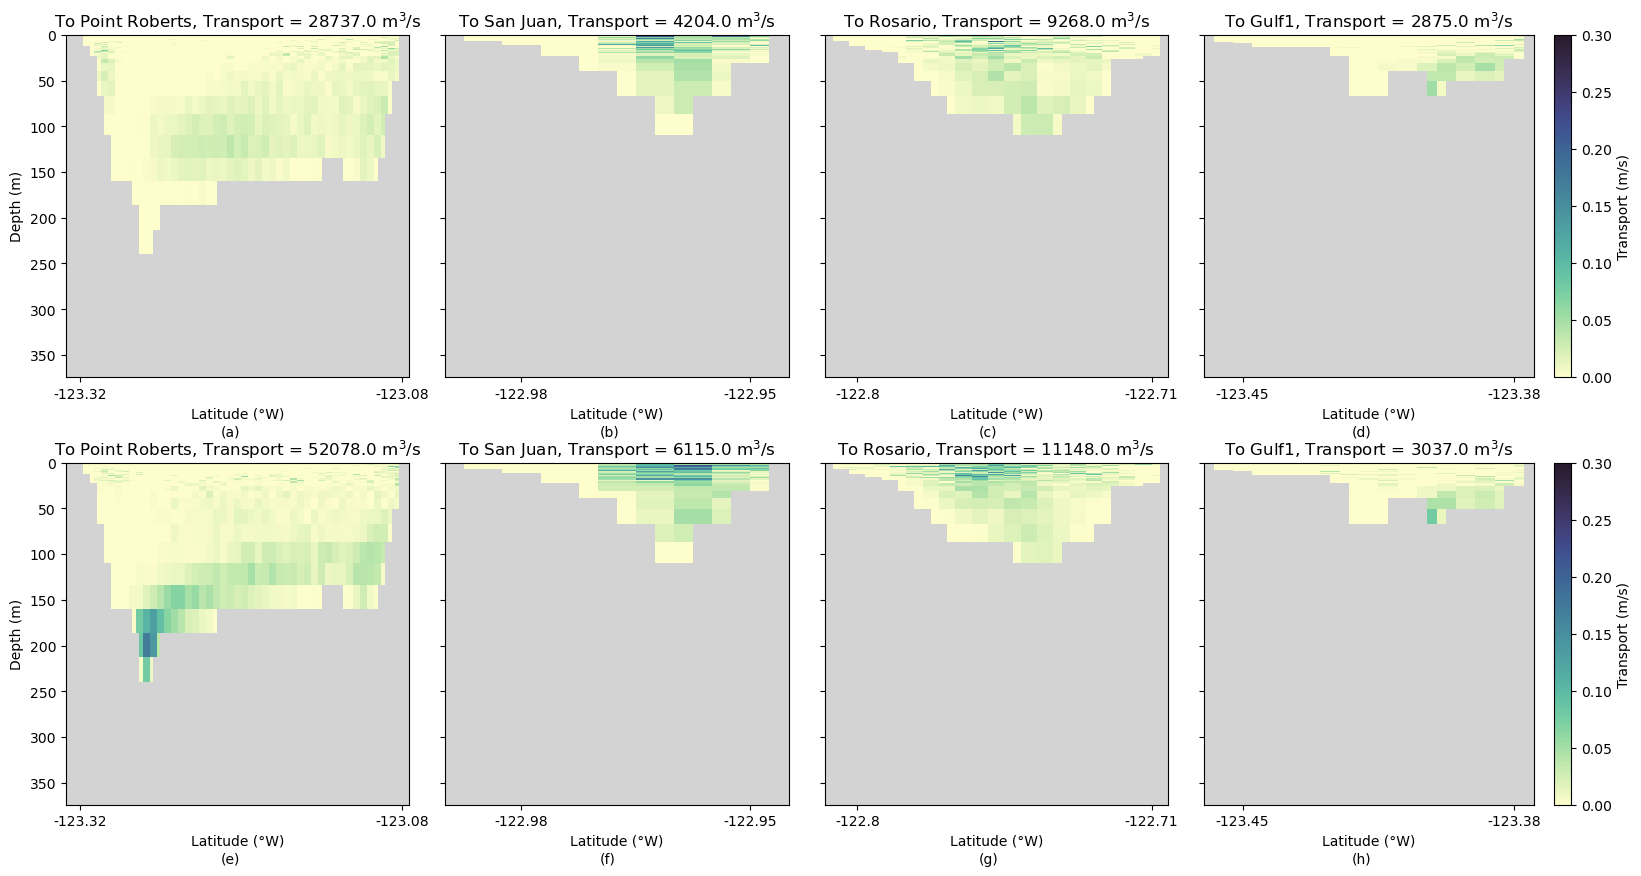

In [12]:
sjcfhspr = get_secdata(data_dict['datafhspr'],5)
rosfhspr = get_secdata(data_dict['datafhspr'],4)
prfhspr = get_secdata(data_dict['datafhspr'],6)
g1fhspr = get_secdata(data_dict['datafhspr'],2)

#In summer

sjcfhspr07 = get_secdata(data_dict['datafhspr07'],5)
rosfhspr07 = get_secdata(data_dict['datafhspr07'],4)
prfhspr07 = get_secdata(data_dict['datafhspr07'],6)
g1fhspr07 = get_secdata(data_dict['datafhspr07'],2)

section_transpfhspr = []
section_transpfhspr07 = []

for section in sectionnum:
    section_transpfhspr.append(get_datat(data_dict['datafhspr'],section,starttime,endtime))
    section_transpfhspr07.append(get_datat(data_dict['datafhspr07'],section,starttime,endtime))
    
fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

title = f'To Point Roberts, Transport = {np.round(section_transpfhspr[5])} m$^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transpfhspr[4])} m$^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transpfhspr[3])} m$^3$/s'
title4 = f'To Gulf1, Transport = {np.round(section_transpfhspr[1])} m$^3$/s'

plotCS(ax1,prfhspr['final_lon'],prfhspr['final_z'],prfhspr['final_transp'],lonWpr,lonEpr,latpr,38,0.3,168,title,False,True)
plotCS(ax2,sjcfhspr['final_lon'],sjcfhspr['final_z'],sjcfhspr['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,168,title2,False,False)
plotCS(ax3,rosfhspr['final_lon'],rosfhspr['final_z'],rosfhspr['final_transp'],lonWros,lonEros,latros,38,0.3,168,title3,False,False)
plotCS(ax4,g1fhspr['final_lon'],g1fhspr['final_z'],g1fhspr['final_transp'],lonWg1,lonEg1,latg1,38,0.3,168,title4,True,False)

ax1.text(0.45, -0.17, "(a)",transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

title = f'To Point Roberts, Transport = {np.round(section_transpfhspr07[5])} m$^3$/s'
title2 = f'To San Juan, Transport = {np.round(section_transpfhspr07[4])} m$^3$/s'
title3 = f'To Rosario, Transport = {np.round(section_transpfhspr07[3])} m$^3$/s'
title4 = f'To Gulf1, Transport = {np.round(section_transpfhspr07[1])} m$^3$/s'

plotCS(ax5,prfhspr07['final_lon'],prfhspr07['final_z'],prfhspr07['final_transp'],lonWpr,lonEpr,latpr,38,0.3,168,title,False,True)
plotCS(ax6,sjcfhspr07['final_lon'],sjcfhspr07['final_z'],sjcfhspr07['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.3,168,title2,False,False)
plotCS(ax7,rosfhspr07['final_lon'],rosfhspr07['final_z'],rosfhspr07['final_transp'],lonWros,lonEros,latros,38,0.3,168,title3,False,False)
plotCS(ax8,g1fhspr07['final_lon'],g1fhspr07['final_z'],g1fhspr07['final_transp'],lonWg1,lonEg1,latg1,38,0.3,168,title4,True,False)

ax5.text(0.45, -0.17, "(e)",transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.subplots_adjust(wspace=0.1,hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/forwardHSPR_section.png',bbox_inches='tight')

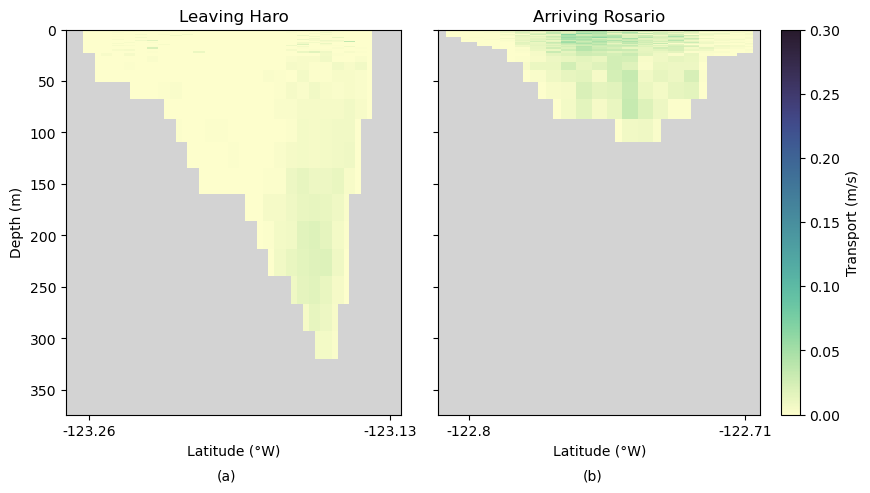

In [13]:
sjcfhspr = get_secdata(data_dict['datafhspr'],5)
rosfhspr = get_secdata(data_dict['datafhspr'],4)
prfhspr = get_secdata(data_dict['datafhspr'],6)
g1fhspr = get_secdata(data_dict['datafhspr'],2)

#In summer

sjcfhspr07 = get_secdata(data_dict['datafhspr07'],5)
rosfhspr07 = get_secdata(data_dict['datafhspr07'],4)
prfhspr07 = get_secdata(data_dict['datafhspr07'],6)
g1fhspr07 = get_secdata(data_dict['datafhspr07'],2)

section_transpfhspr = []
section_transpfhspr07 = []

for section in sectionnum:
    section_transpfhspr.append(get_datat(data_dict['datafhspr'],section,starttime,endtime))
    section_transpfhspr07.append(get_datat(data_dict['datafhspr07'],section,starttime,endtime))
    
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'width_ratios':[1,1.2]})

title = f'Leaving Haro'
title2 = f'Arriving Rosario'

plotCS(ax1,harobrspr['final_lon'],harobrspr['final_z'],harobrspr['final_transp'],lonWharo,lonEharo,latharo,38,0.3,168,title,False,True)
plotCS(ax2,harobrspr['init_lon'],harobrspr['init_z'],harobrspr['init_transp'],lonWros,lonEros,latros,38,0.3,168,title2,True,False)

ax1.text(0.45, -0.17, "(a)",transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)

fig.subplots_adjust(wspace=0.1,hspace=0.25)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/harotoros_mod_section.png',bbox_inches='tight')

Text(0.45, -0.17, '(d)')

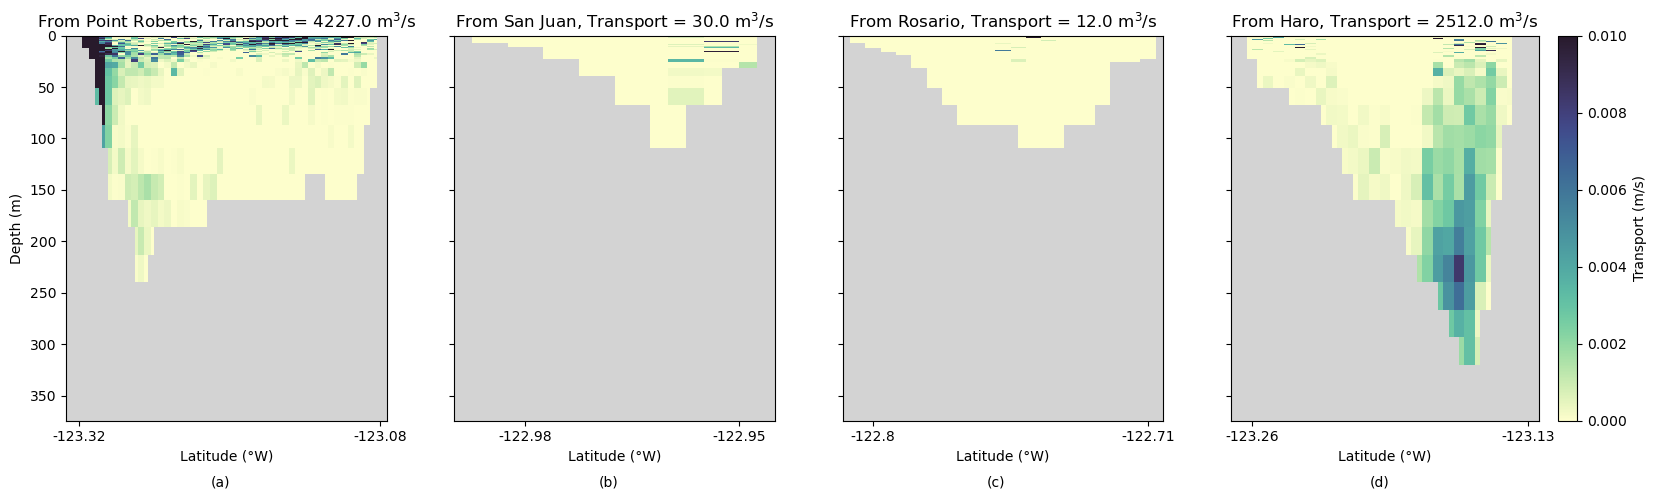

In [14]:
harobg1 = get_secdata(data_dict['databg1'],6)
rosbg1 = get_secdata(data_dict['databg1'],4)
sjcbg1 = get_secdata(data_dict['databg1'],5)
prbg1 = get_secdata(data_dict['databg1'],2)

section_transpbg1 = []

for section in sectionnum:
    section_transpbg1.append(get_datat(data_dict['databg1'],section,starttime,endtime))
    
fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(20,5),gridspec_kw={'width_ratios':[1,1,1,1.2]})

title = f'From Point Roberts, Transport = {np.round(section_transpbg1[1])} m$^3$/s'
title4 = f'From Haro, Transport = {np.round(section_transpbg1[5])} m$^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transpbg1[4])} m$^3$/s'
title3 = f'From Rosario, Transport = {np.round(section_transpbg1[3])} m$^3$/s'


plotCS(ax1,prbg1['final_lon'],prbg1['final_z'],prbg1['final_transp'],lonWpr,lonEpr,latpr,38,0.01,168,title,False,True)
plotCS(ax4,harobg1['final_lon'],harobg1['final_z'],harobg1['final_transp'],lonWharo,lonEharo,latharo,38,0.01,168,title4,True,False)
plotCS(ax2,sjcbg1['final_lon'],sjcbg1['final_z'],sjcbg1['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.01,168,title2,False,False)
plotCS(ax3,rosbg1['final_lon'],rosbg1['final_z'],rosbg1['final_transp'],lonWros,lonEros,latros,38,0.01,168,title3,False,False)


ax1.text(0.45, -0.17, "(a)",transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

Text(0.45, -0.17, '(d)')

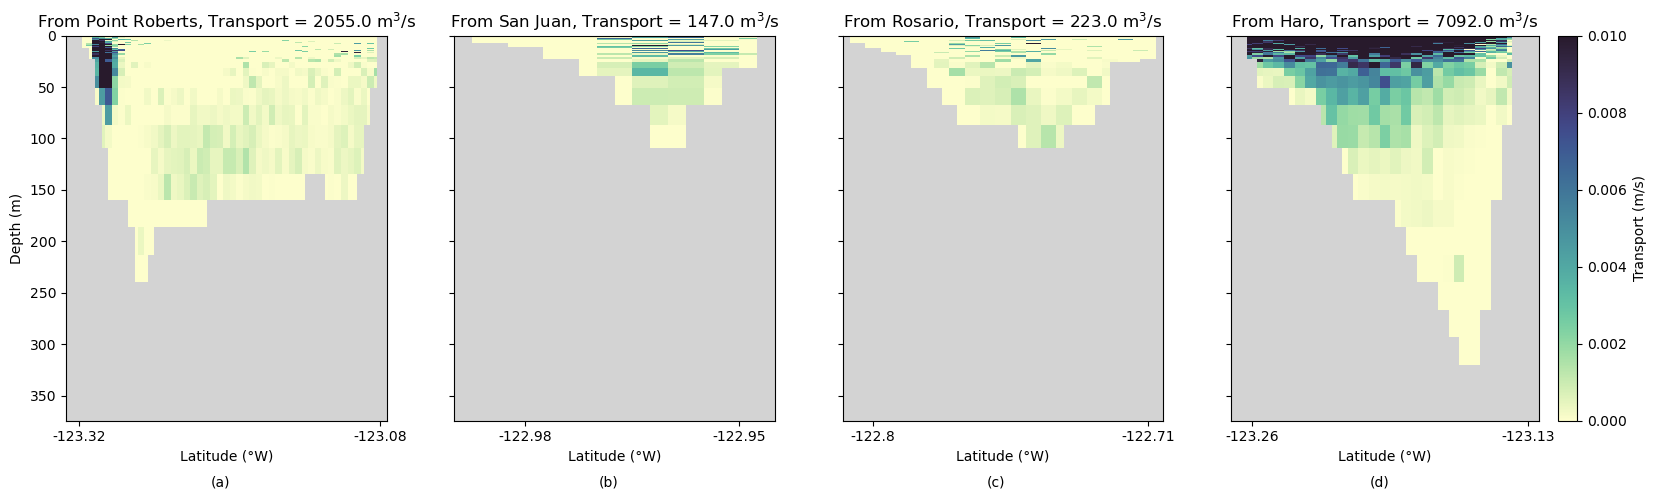

In [15]:
harofg1 = get_secdata(data_dict['datafg1'],6)
rosfg1 = get_secdata(data_dict['datafg1'],4)
sjcfg1 = get_secdata(data_dict['datafg1'],5)
prfg1 = get_secdata(data_dict['datafg1'],2)

section_transpfg1 = []

for section in sectionnum:
    section_transpfg1.append(get_datat(data_dict['datafg1'],section,starttime,endtime))
    
fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4,figsize=(20,5),gridspec_kw={'width_ratios':[1,1,1,1.2]})

title = f'From Point Roberts, Transport = {np.round(section_transpfg1[1])} m$^3$/s'
title4 = f'From Haro, Transport = {np.round(section_transpfg1[5])} m$^3$/s'
title2 = f'From San Juan, Transport = {np.round(section_transpfg1[4])} m$^3$/s'
title3 = f'From Rosario, Transport = {np.round(section_transpfg1[3])} m$^3$/s'


plotCS(ax1,prfg1['final_lon'],prfg1['final_z'],prfg1['final_transp'],lonWpr,lonEpr,latpr,38,0.01,168,title,False,True)
plotCS(ax4,harofg1['final_lon'],harofg1['final_z'],harofg1['final_transp'],lonWharo,lonEharo,latharo,38,0.01,168,title4,True,False)
plotCS(ax2,sjcfg1['final_lon'],sjcfg1['final_z'],sjcfg1['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.01,168,title2,False,False)
plotCS(ax3,rosfg1['final_lon'],rosfg1['final_z'],rosfg1['final_transp'],lonWros,lonEros,latros,38,0.01,168,title3,False,False)


ax1.text(0.45, -0.17, "(a)",transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

Backwards Rosario seeding in EJdF region (south) to highlight wierdness of Rosario.

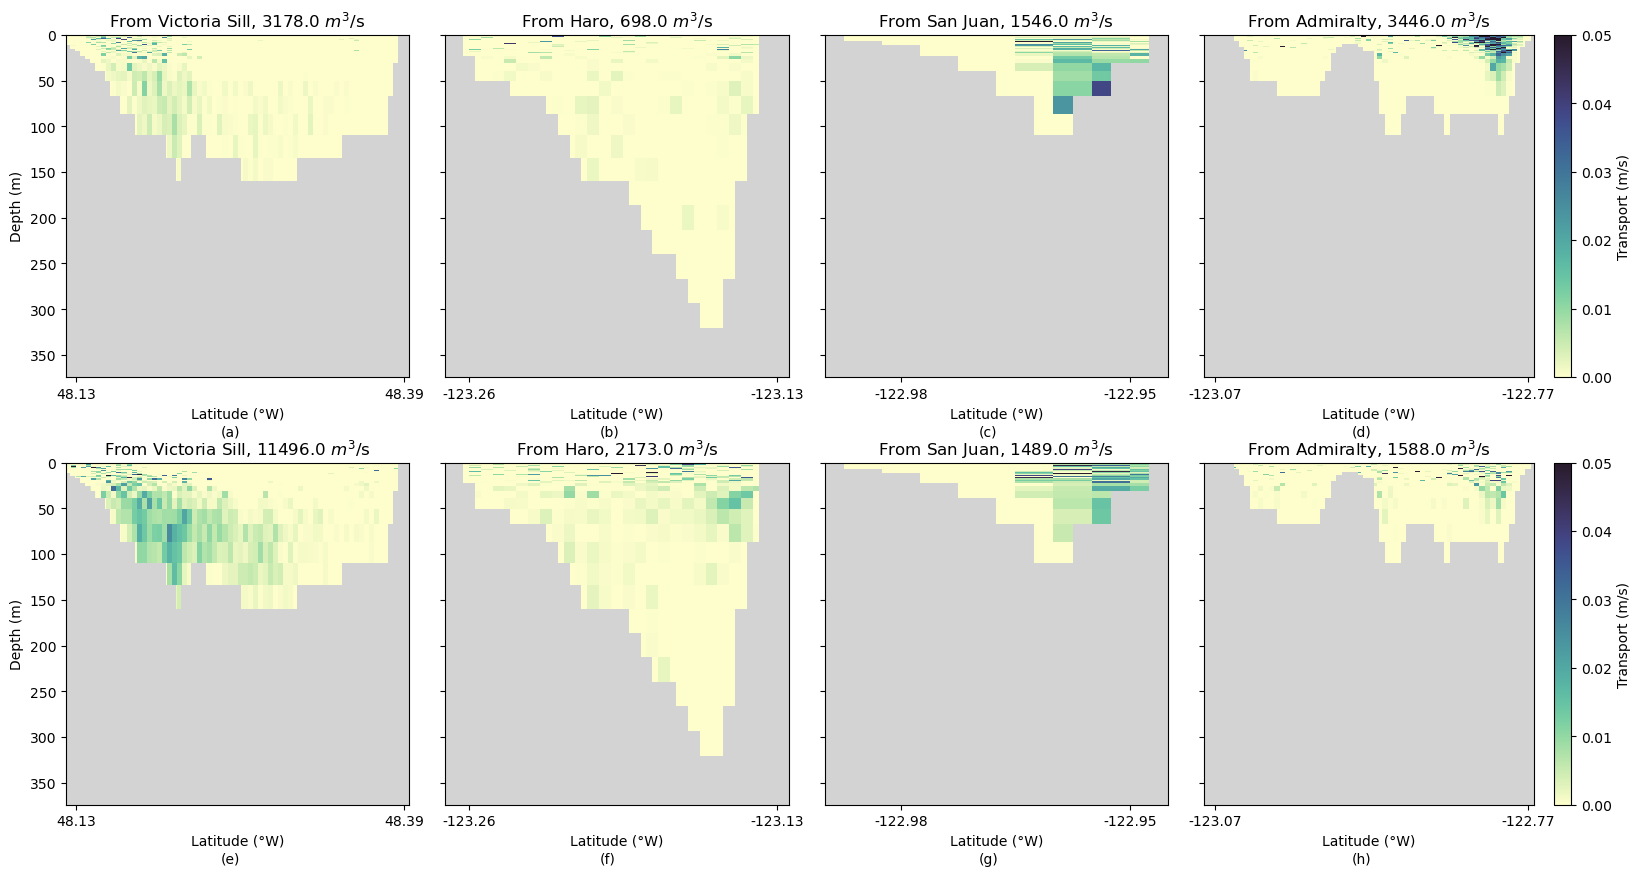

In [16]:
vsbrsvs = get_secdata(data_dict['databrsvs'],4)
admbrsvs = get_secdata(data_dict['databrsvs'],2)
harobrsvs = get_secdata(data_dict['databrsvs'],6)
sjcbrsvs = get_secdata(data_dict['databrsvs'],5)

vsbrsvs07 = get_secdata(data_dict['databrsvs07'],4)
admbrsvs07 = get_secdata(data_dict['databrsvs07'],2)
harobrsvs07 = get_secdata(data_dict['databrsvs07'],6)
sjcbrsvs07 = get_secdata(data_dict['databrsvs07'],5)

section_transpbrsvs = []
section_transpbrsvs07 = []

lonWvs = 235
lonEvs = 304
latvs = 178

for section in sectionnum:
    section_transpbrsvs.append(get_datat(data_dict['databrsvs'],section,starttime,169))
    section_transpbrsvs07.append(get_datat(data_dict['databrsvs07'],section,starttime,endtime))    

title = f'From Victoria Sill, {np.round(section_transpbrsvs[3])} $m^3$/s'
title2 = f'From Haro, {np.round(section_transpbrsvs[5])} $m^3$/s'
title3 = f'From San Juan, {np.round(section_transpbrsvs[4])} $m^3$/s'
title4 = f'From Admiralty, {np.round(section_transpbrsvs[1])} $m^3$/s'

fig,[[ax1,ax2,ax3,ax4],[ax5,ax6,ax7,ax8]] = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'width_ratios':[1,1,1,1.2]})

plotCS(ax1,vsbrsvs['final_lat'],vsbrsvs['final_z'],vsbrsvs['final_transp'],lonWvs,lonEvs,latvs,38,0.05,168,title,False,True,NW=True)
plotCS(ax2,harobrsvs['final_lon'],harobrsvs['final_z'],harobrsvs['final_transp'],lonWharo,lonEharo,latharo,38,0.05,168,title2,False,False)
plotCS(ax3,sjcbrsvs['final_lon'],sjcbrsvs['final_z'],sjcbrsvs['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.05,168,title3,False,False)
plotCS(ax4,admbrsvs['final_lon'],admbrsvs['final_z'],admbrsvs['final_transp'],lonWadm,lonEadm,latadm,38,0.05,168,title4,True,False)

title = f'From Victoria Sill, {np.round(section_transpbrsvs07[3])} $m^3$/s'
title2 = f'From Haro, {np.round(section_transpbrsvs07[5])} $m^3$/s'
title3 = f'From San Juan, {np.round(section_transpbrsvs07[4])} $m^3$/s'
title4 = f'From Admiralty, {np.round(section_transpbrsvs07[1])} $m^3$/s'

plotCS(ax5,vsbrsvs07['final_lat'],vsbrsvs07['final_z'],vsbrsvs07['final_transp'],lonWvs,lonEvs,latvs,38,0.05,168,title,False,True,NW=True)
plotCS(ax6,harobrsvs07['final_lon'],harobrsvs07['final_z'],harobrsvs07['final_transp'],lonWharo,lonEharo,latharo,38,0.05,168,title2,False,False)
plotCS(ax7,sjcbrsvs07['final_lon'],sjcbrsvs07['final_z'],sjcbrsvs07['final_transp'],lonWsjc,lonEsjc,latsjc,38,0.05,168,title3,False,False)
plotCS(ax8,admbrsvs07['final_lon'],admbrsvs07['final_z'],admbrsvs07['final_transp'],lonWadm,lonEadm,latadm,38,0.05,168,title4,True,False)

fig.subplots_adjust(wspace=0.1,hspace=0.25)

ax1.text(0.45, -0.17, "(a)",transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)

ax5.text(0.45, -0.17, "(e)",transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
ax7.text(0.45, -0.17, "(g)", transform=ax7.transAxes)
ax8.text(0.45, -0.17, "(h)", transform=ax8.transAxes)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/rosb_EJdF_xsections.png',bbox_inches='tight')

In [17]:
vsbrsvs07['final_lat'][vsbrsvs07['final_lat']>48.36]

<xarray.DataArray 'final_lat' (ntraj: 16)>
array([48.362608, 48.366074, 48.369373, 48.370692, 48.369613, 48.372002,
       48.36216 , 48.366706, 48.368775, 48.384991, 48.363047, 48.370555,
       48.366701, 48.361208, 48.367214, 48.362817])
Dimensions without coordinates: ntraj
Attributes:
    title:     What is final_lat ?
    longname:  Final position in latitude
    units:     No dimension

### Through Strait cross sections

#### South through Haro to VS

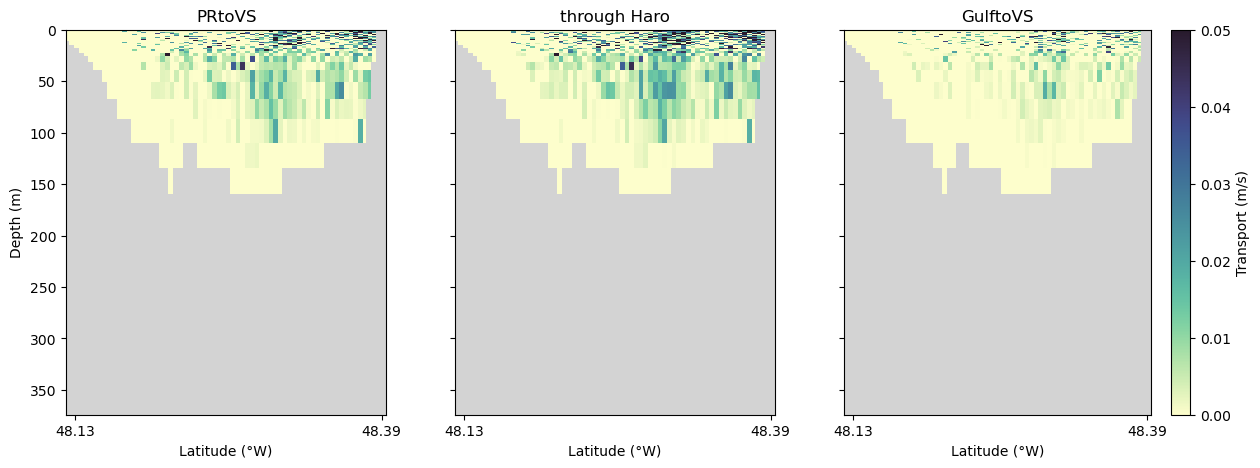

In [18]:
datafpr_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafgulf_haro = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf_haro3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafpr_haro07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_haro3/01jun18_s1t50/ariane_positions_quantitative.nc')
datafgulf_haro07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf_haro3/01jun18_s1t50/ariane_positions_quantitative.nc')

prtovs_haro = get_secdata(datafpr_haro,6)
gulftovs_haro = get_secdata(datafgulf_haro,7)
prtovs_haro07 = get_secdata(datafpr_haro07,6)
gulftovs_haro07 = get_secdata(datafgulf_haro07,7)

transp_prtovs_haro = prtovs_haro['final_transp'].values
transp_tovs_haro = np.append(transp_prtovs_haro,gulftovs_haro['final_transp'].values)
transp_prtovs_haro07 = prtovs_haro07['final_transp'].values
transp_tovs_haro07 = np.append(transp_prtovs_haro07,gulftovs_haro07['final_transp'].values)

lat_prtovs_haro = prtovs_haro['final_lat'].values
lat_tovs_haro = np.append(lat_prtovs_haro,gulftovs_haro['final_lat'].values)
lat_prtovs_haro07 = prtovs_haro07['final_lat'].values
lat_tovs_haro07 = np.append(lat_prtovs_haro07,gulftovs_haro07['final_lat'].values)

z_prtovs_haro = prtovs_haro['final_z'].values
z_tovs_haro = np.append(z_prtovs_haro,gulftovs_haro['final_z'].values)
z_prtovs_haro07 = prtovs_haro07['final_z'].values
z_tovs_haro07 = np.append(z_prtovs_haro07,gulftovs_haro07['final_z'].values)

sal_prtovs_haro = prtovs_haro['final_salt'].values
sal_tovs_haro = np.append(sal_prtovs_haro,gulftovs_haro['final_salt'])
sal_prtovs_haro07 = prtovs_haro07['final_salt'].values
sal_tovs_haro07 = np.append(sal_prtovs_haro07,gulftovs_haro07['final_salt'])

fig,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,1.2]})

plotCS(ax1,lat_prtovs_haro,z_prtovs_haro,transp_prtovs_haro,lonWvs,lonEvs,latvs,38,0.05,23,'PRtoVS',False,True,NW=True)
plotCS(ax2,lat_tovs_haro,z_tovs_haro,transp_tovs_haro,lonWvs,lonEvs,latvs,38,0.05,23,'through Haro',False,False,NW=True)
plotCS(ax3,gulftovs_haro['final_lat'],gulftovs_haro['final_z'],gulftovs_haro['final_transp'],lonWvs,lonEvs,latvs,38,0.05,23,'GulftoVS',True,False,NW=True)

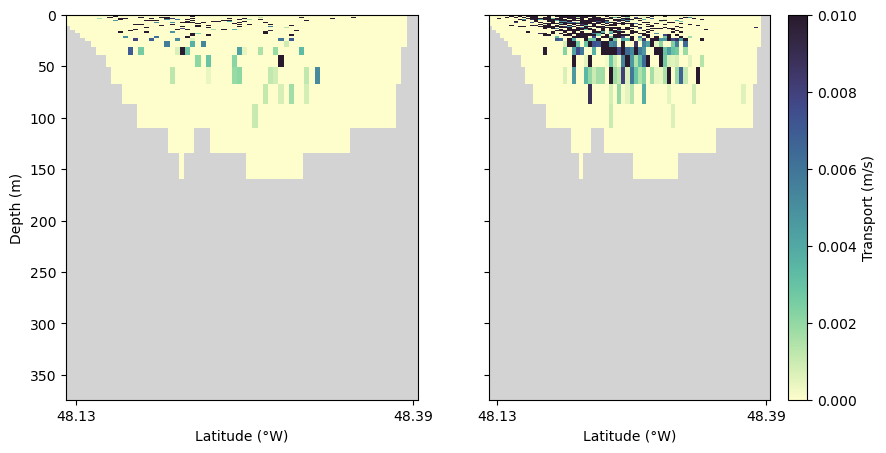

In [19]:
datafpr_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafpr_ros07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forpr_ros3/01jun18_s1t50/ariane_positions_quantitative.nc')
datafgulf_ros = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf_ros3/01jan18_s1t50/ariane_positions_quantitative.nc')
datafgulf_ros07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf_ros3/01jun18_s1t50/ariane_positions_quantitative.nc')

fpr_ros = get_secdata(datafpr_ros,4)
fpr_ros07 = get_secdata(datafpr_ros07,4)

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotCS(ax1,fpr_ros['final_lat'],fpr_ros['final_z'],fpr_ros['final_transp'],lonWvs,lonEvs,latvs,38,0.01,23,'',False,True,NW=True)
plotCS(ax2,fpr_ros07['final_lat'],fpr_ros07['final_z'],fpr_ros07['final_transp'],lonWvs,lonEvs,latvs,38,0.01,23,'',True,False,NW=True)

#### Look at salinity

/tmp/ipykernel_11286/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_11286/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


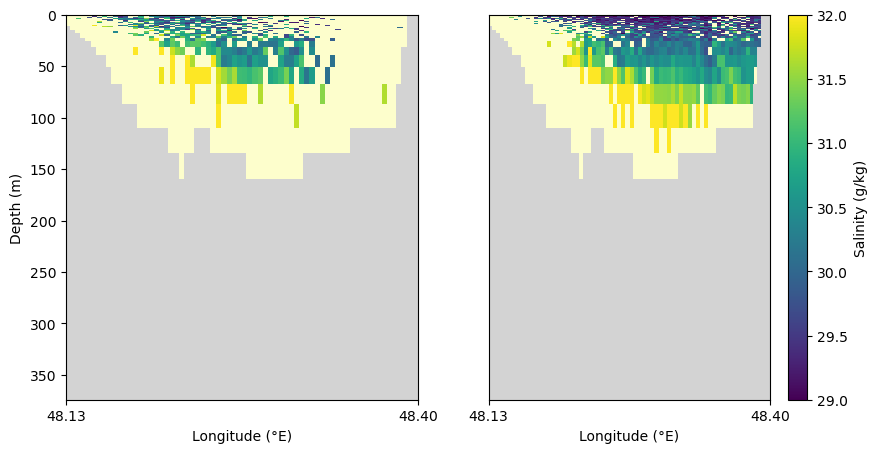

In [20]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',fpr_ros07['final_lat'],fpr_ros07['final_z'],fpr_ros07['final_salt'],lonWvs,lonEvs,latvs,38,23,'',False,True,vmin=29,vmax=32,NW=True)
plotTS(ax2,'sal',lat_tovs_haro07,z_tovs_haro07,sal_tovs_haro07,lonWvs,lonEvs,latvs,38,23,'',True,False,vmin=29,vmax=32,NW=True)

Look at mean of surface vs. mean of deep (pick 50 m depth?)

In [21]:
sal_haro_mean = sal_tovs_haro.mean()
sal_ros_mean = fpr_ros['final_salt'].values.mean()

depth = -50
#Split into surface deep

depth_prtovs_haro = prtovs_haro['final_depth']
depth_tovs_haro = np.append(depth_prtovs_haro,gulftovs_haro['final_depth'])
depth_prtovs_haro07 = prtovs_haro07['final_depth']
depth_tovs_haro07 = np.append(depth_prtovs_haro07,gulftovs_haro07['final_depth'])
transp_thru_haro_surf = transp_tovs_haro[depth_tovs_haro > depth]
transp_thru_haro_deep = transp_tovs_haro[depth_tovs_haro < depth]
transp_thru_haro_surf07 = transp_tovs_haro07[depth_tovs_haro07 > depth]
transp_thru_haro_deep07 = transp_tovs_haro07[depth_tovs_haro07 < depth]

#January
sal_thru_haro_surf = sal_tovs_haro[depth_tovs_haro > depth]
print('Haro Surface:',sal_thru_haro_surf.mean())
sal_thru_haro_deep = sal_tovs_haro[depth_tovs_haro < depth]
print('Haro deep:',sal_thru_haro_deep.mean())

sal_thru_ros_surf = fpr_ros['final_salt'][fpr_ros['final_depth'] > depth].values
print('Rosario surface:',sal_thru_ros_surf.mean())
sal_thru_ros_deep = fpr_ros['final_salt'][fpr_ros['final_depth'] < depth].values
print('Rosario deep:',sal_thru_ros_deep.mean(),'\n','----')

#June
sal_haro_mean07 = sal_tovs_haro07.mean()
sal_ros_mean07 = fpr_ros07['final_salt'].values.mean()
print(len(sal_tovs_haro07),len(fpr_ros07['final_salt']))

sal_thru_haro_surf07 = sal_tovs_haro07[depth_tovs_haro07 > depth]
print('Haro surface, june:',sal_thru_haro_surf07.mean())
sal_thru_haro_deep07 = sal_tovs_haro07[depth_tovs_haro07 < depth]
print('Haro deep, june:',sal_thru_haro_deep07.mean())

sal_thru_ros_surf07 = fpr_ros07['final_salt'][fpr_ros07['final_depth'] >= depth].values
print('Rosario surface, june:',sal_thru_ros_surf07.mean())
sal_thru_ros_deep07 = fpr_ros07['final_salt'][fpr_ros07['final_depth'] < depth].values
print('Rosario deep, june:',sal_thru_ros_deep07.mean(),'\n ----')
print('Haro june:',sal_haro_mean07)
print('Rosario june:',sal_ros_mean07)
print(sal_thru_haro_surf.std())
print(sal_thru_haro_deep.std())
print(sal_thru_ros_surf.std())
print(sal_thru_haro_surf.std())
print('Std rosario surface:',sal_thru_ros_surf07.std())
print('Std haro surface:',sal_thru_haro_surf07.std())
len(sal_thru_ros_surf07),len(sal_thru_haro_surf07)

Haro Surface: 30.957914
Haro deep: 31.184982
Rosario surface: 30.717127
Rosario deep: 31.065716 
 ----
3042 864
Haro surface, june: 29.95254
Haro deep, june: 31.619215
Rosario surface, june: 30.397476
Rosario deep, june: 31.978699 
 ----
Haro june: 30.071432
Rosario june: 30.432247
0.24381319
0.2933433
0.3735386
0.24381319
Std rosario surface: 0.7104649
Std haro surface: 0.76169956


(845, 2825)

In [22]:
sal_thru_haro_deep.mean()-sal_thru_ros_deep.mean()
sal_thru_haro_surf.mean()-sal_thru_ros_surf.mean()

0.2407875

In [23]:
len(sal_thru_haro_surf),len(sal_thru_ros_surf)

(1553, 139)

Plot histograms (line with mean)

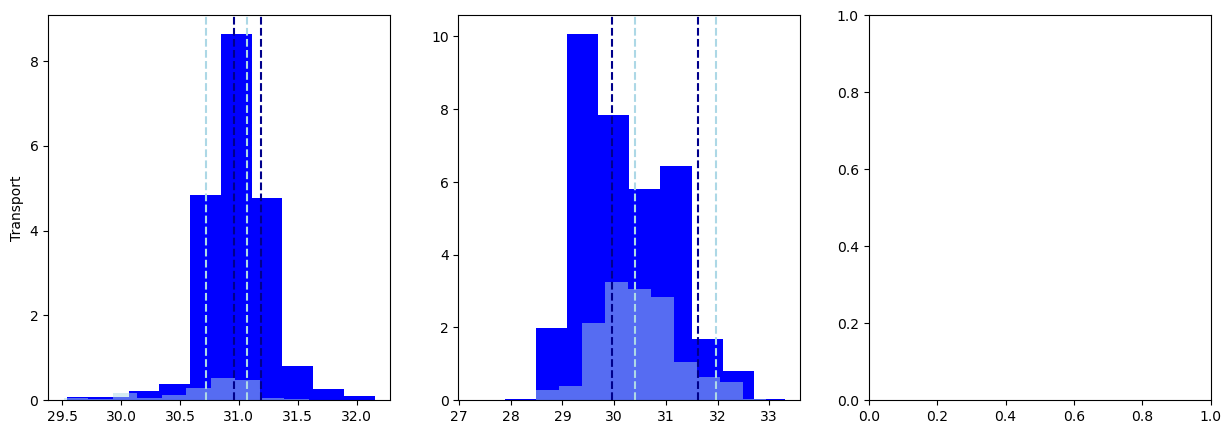

In [24]:
# P
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(sal_tovs_haro,bins=10,weights=transp_tovs_haro/23/1000,color='blue',label='')
ax[0].hist(fpr_ros['final_salt'],bins=10,weights=fpr_ros['final_transp']/23/1000,color='lightblue',alpha=0.5,label='')
ax[0].set_ylabel('Transport')
ax[1].hist(sal_tovs_haro07,bins=10,weights=transp_tovs_haro07/23/1000,color='blue',label='')
ax[1].hist(fpr_ros07['final_salt'],bins=10,weights=fpr_ros07['final_transp']/23/1000,color='lightblue',alpha=0.5,label='')

# ax[0].axvline(sal_haro_mean,color='grey',ls='--')
# ax[0].axvline(sal_ros_mean,color='lightblue')
# ax[1].axvline(sal_haro_mean07,color='darkblue',ls='--')
# ax[1].axvline(sal_ros_mean07,color='lightblue',ls='--')
ax[1].axvline(sal_thru_haro_deep07.mean(),color='darkblue',ls='--')
ax[1].axvline(sal_thru_ros_deep07.mean(),color='lightblue',ls='--')
ax[1].axvline(sal_thru_haro_surf07.mean(),color='darkblue',ls='--')
ax[1].axvline(sal_thru_ros_surf07.mean(),color='lightblue',ls='--')

ax[0].axvline(sal_thru_haro_deep.mean(),color='darkblue',ls='--')
ax[0].axvline(sal_thru_ros_deep.mean(),color='lightblue',ls='--')
ax[0].axvline(sal_thru_haro_surf.mean(),color='darkblue',ls='--')
ax[0].axvline(sal_thru_ros_surf.mean(),color='lightblue',ls='--')

(array([0.01146752, 0.00625693, 0.02294146, 0.09655181, 1.59463206,
        5.68596518, 6.11687974, 4.33121571, 4.47683589, 2.83576037,
        4.20579863, 1.74845864, 0.66334405, 0.25766213, 0.04491131]),
 array([27.28936195, 27.64527321, 28.00118637, 28.35709763, 28.71301079,
        29.06892204, 29.42483521, 29.78074646, 30.13665962, 30.49257088,
        30.84848404, 31.20439529, 31.56030846, 31.91621971, 32.27213287,
        32.62804413]),
 <BarContainer object of 15 artists>)

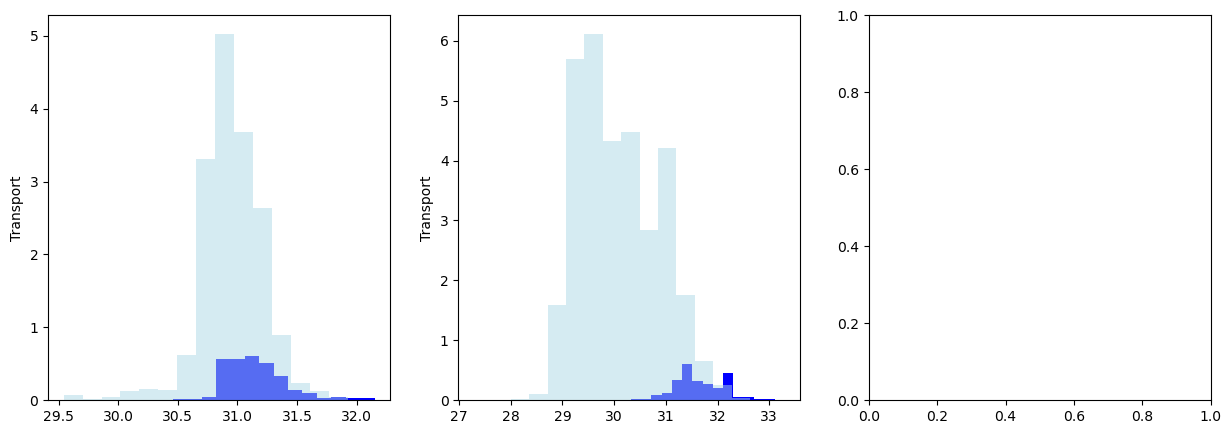

In [25]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(sal_thru_haro_deep,bins=15,weights=transp_thru_haro_deep/23/1000,color='blue',label='')
ax[0].set_ylabel('Transport')
ax[0].hist(sal_thru_haro_surf,bins=15,weights=transp_thru_haro_surf/23/1000,color='lightblue',alpha=0.5,label='')
# ax[0].set_xlim([29,32])

ax[1].hist(sal_thru_haro_deep07,bins=15,weights=transp_thru_haro_deep07/23/1000,color='blue',label='')
ax[1].set_ylabel('Transport')
ax[1].hist(sal_thru_haro_surf07,bins=15,weights=transp_thru_haro_surf07/23/1000,color='lightblue',alpha=0.5,label='')


In [26]:
transp_thru_haro_surf07.sum()/24,transp_thru_haro_deep07.sum()/24,transp_thru_haro_surf07.sum()/transp_thru_haro_deep07.sum()

(30761.236383679312, 2493.991870219208, 12.33413659082039)

In [27]:
depth_ros07 = fpr_ros07['final_depth']
transp_thru_ros_surf07 = fpr_ros07['final_transp'][depth_ros07 > depth ].values/24
transp_thru_ros_deep07 = fpr_ros07['final_transp'][depth_ros07 <= depth ].values/24
transp_thru_ros_surf07.sum(),transp_thru_ros_deep07.sum(),transp_thru_ros_surf07.sum()/transp_thru_ros_deep07.sum()

(13353.199114460062, 241.060176497586, 55.393633691269535)

- Proportionately more deep flow in Haro (deeper strait)
- More surface flow because looking at flow south through Haro/Ros

- Look at leaving PR vs. arriving VS
- Then look at admiralty

#### Leaving PR vs. arriving VS

/tmp/ipykernel_11286/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_11286/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


Text(0.5, 1.0, 'Through Rosario')

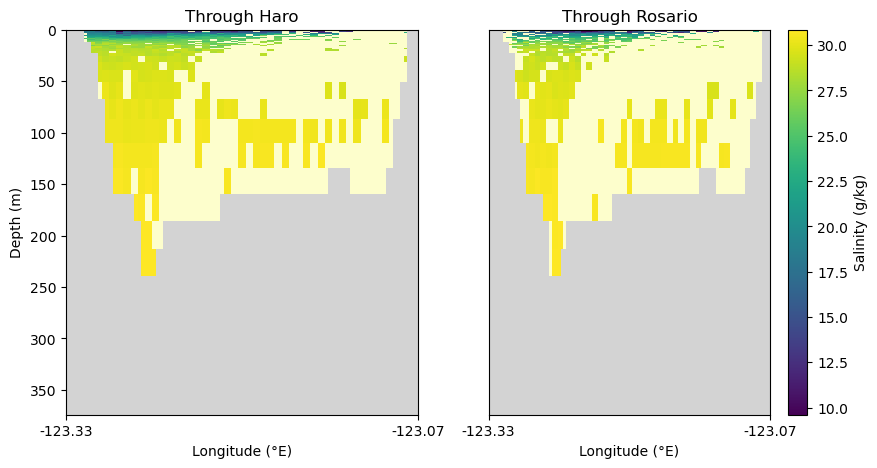

In [28]:
initsal_prtovs_haro07 = prtovs_haro07['init_salt'].values
# initsal_tovs_haro = np.append(initsal_prtovs_haro, gulftovs_haro07['init_salt'].values)

initdep_prtovs_haro = prtovs_haro07['init_depth'].values
initsal_prtovs_surf07 = initsal_prtovs_haro07[initdep_prtovs_haro > depth]
initsal_prtovs_deep07 = initsal_prtovs_haro07[initdep_prtovs_haro <= depth]

initdep_prtovs_ros = fpr_ros07['init_depth'].values
initsal_surf_ros07 = fpr_ros07['init_salt'][initdep_prtovs_ros > depth]
initsal_deep_ros07 = fpr_ros07['init_salt'][initdep_prtovs_ros <= depth]

fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

plotTS(ax1,'sal',prtovs_haro07['init_lon'],prtovs_haro07['init_z'],prtovs_haro07['init_salt'],lonWpr,lonEpr,latpr,38,23,'',False,True)
plotTS(ax2,'sal',fpr_ros07['init_lon'],fpr_ros07['init_z'],fpr_ros07['init_salt'],lonWpr,lonEpr,latpr,38,23,'',True,False)
ax1.set_title('Through Haro')
ax2.set_title('Through Rosario')

In [29]:
prtovs_haro07.keys()

dict_keys(['final_salt', 'final_transp', 'final_lon', 'final_lat', 'final_depth', 'final_section', 'final_z', 'final_temp', 'init_lon', 'init_z', 'init_salt', 'init_temp', 'init_transp', 'init_depth'])

In [30]:
initsal_prtovs_haro07.mean(),fpr_ros07['init_salt'].values.mean()

(23.879162, 24.351221)

In [31]:
initsal_prtovs_haro07.std(),fpr_ros07['init_salt'].values.std()

(5.1847916, 5.2932644)

In [32]:
initsal_prtovs_deep07.std(),initsal_deep_ros07.values.std()

(0.25030914, 0.24040973)

In [33]:
len(initsal_prtovs_deep07),len(initsal_deep_ros07)

(140, 109)

In [34]:
initsal_prtovs_deep07.mean(),initsal_deep_ros07.values.mean(),initsal_prtovs_deep07.mean()-initsal_deep_ros07.values.mean()

(30.381744, 30.453865, -0.07212067)

In [35]:
initsal_prtovs_surf07.std(),initsal_surf_ros07.values.std()

(4.997412, 5.0894446)

In [36]:
initsal_prtovs_surf07.mean(),initsal_surf_ros07.values.mean(),initsal_prtovs_surf07.mean()-initsal_surf_ros07.values.mean()

(23.245646, 23.470179, -0.22453308)

In [37]:
len(initsal_prtovs_surf07),len(initsal_surf_ros07)

(1437, 755)

In [38]:
initsal_surf_ros07.values.mean()-sal_thru_ros_surf07.mean()

-6.9272976

In [39]:
initsal_deep_ros07.values.mean()-sal_thru_ros_deep07.mean()

-1.5248337

In [40]:
initsal_prtovs_surf07.mean()-sal_thru_haro_surf.mean()

-7.712269

In [41]:
initsal_prtovs_deep07.mean()-sal_thru_haro_deep.mean()

-0.8032379

Look at property modification to admiralty 

In [42]:
prtoadm_haro07['final_salt']

NameError: name 'prtoadm_haro07' is not defined

/tmp/ipykernel_4940/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_4940/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_4940/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_4940/1237841159.py:64: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


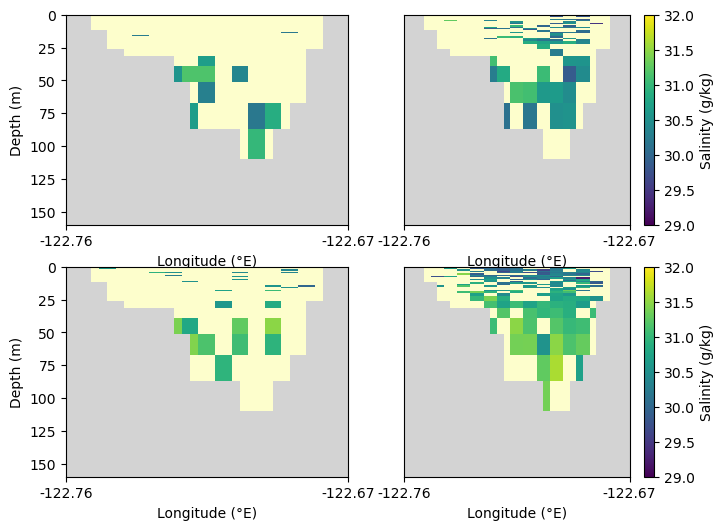

In [ ]:
prtoadm_haro07 = get_secdata(datafpr_haro07,2)
prtoadm_ros07 = get_secdata(datafpr_ros07,2)
prtoadm_haro = get_secdata(datafpr_haro,2)
prtoadm_ros = get_secdata(datafpr_ros,2)

lonWadm = 250
lonEadm = 268
latadm = 200

fig,[[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(8,6))
plotTS(ax1,'sal',prtoadm_haro['final_lon'],prtoadm_haro['final_z'],prtoadm_haro['final_salt'],lonWadm,lonEadm,latadm,30,24,'',False,True,vmin=29,vmax=32)
plotTS(ax2,'sal',prtoadm_ros['final_lon'],prtoadm_ros['final_z'],prtoadm_ros['final_salt'],lonWadm,lonEadm,latadm,30,24,'',True,False,vmin=29,vmax=32)
plotTS(ax3,'sal',prtoadm_haro07['final_lon'],prtoadm_haro07['final_z'],prtoadm_haro07['final_salt'],lonWadm,lonEadm,latadm,30,24,'',False,True,vmin=29,vmax=32)
plotTS(ax4,'sal',prtoadm_ros07['final_lon'],prtoadm_ros07['final_z'],prtoadm_ros07['final_salt'],lonWadm,lonEadm,latadm,30,24,'',True,False,vmin=29,vmax=32)

In [ ]:
sal_prtoadm_ros_mean = prtoadm_ros['final_salt'].values.mean()
sal_prtoadm_ros07_mean = prtoadm_ros07['final_salt'].values.mean()
sal_prtoadm_haro_mean = prtoadm_haro['final_salt'].values.mean()
sal_prtoadm_haro07_mean = prtoadm_haro07['final_salt'].values.mean()
depth_prtoadm_ros = prtoadm_ros['final_depth'].values
depth_prtoadm_haro = prtoadm_haro['final_depth'].values
depth_prtoadm_ros07 = prtoadm_ros07['final_depth'].values
depth_prtoadm_haro07 = prtoadm_haro07['final_depth'].values

sal_prtoadm_ros_surf = prtoadm_ros['final_salt'].values[depth_prtoadm_ros > depth]
sal_prtoadm_ros_deep = prtoadm_ros['final_salt'].values[depth_prtoadm_ros <= depth]
sal_prtoadm_haro_surf = prtoadm_haro['final_salt'].values[depth_prtoadm_haro > depth]
sal_prtoadm_haro_deep = prtoadm_haro['final_salt'].values[depth_prtoadm_haro <= depth]
sal_prtoadm_ros_surf07 = prtoadm_ros07['final_salt'].values[depth_prtoadm_ros07 > depth]
sal_prtoadm_ros_deep07 = prtoadm_ros07['final_salt'].values[depth_prtoadm_ros07 <= depth]
sal_prtoadm_haro_surf07 = prtoadm_haro07['final_salt'].values[depth_prtoadm_haro07 > depth]
sal_prtoadm_haro_deep07 = prtoadm_haro07['final_salt'].values[depth_prtoadm_haro07 <= depth]

#Mean Haro Surface vs. mean Rosario Surface
print('Haro surface:',sal_prtoadm_haro_surf.mean())
print('Rosario surface:',sal_prtoadm_ros_surf.mean())

# Mean Haro deep vs. mean rosario deep
print('Haro deep:',sal_prtoadm_haro_deep.mean())
print('Rosario deep:',sal_prtoadm_ros_deep.mean())
print('Haro:',sal_prtoadm_haro_mean)
print('Rosario:',sal_prtoadm_ros_mean)
print('----')

#Mean Haro Surface vs. mean Rosario Surface
print('Haro surface (june):',sal_prtoadm_haro_surf07.mean())
print('Rosario surface (june):',sal_prtoadm_ros_surf07.mean())

# Mean Haro deep vs. mean rosario deep
print('Haro deep (june):',sal_prtoadm_haro_deep07.mean())
print('Rosario deep (june):',sal_prtoadm_ros_deep07.mean())
print('Haro:',sal_prtoadm_haro07_mean)
print('Rosario:',sal_prtoadm_ros07_mean)

Haro surface: 30.613558
Rosario surface: 30.432467
Haro deep: 30.605154
Rosario deep: 30.415577
Haro: 30.610325
Rosario: 30.430487
----
Haro surface (june): 30.783644
Rosario surface (june): 30.558851
Haro deep (june): 31.1953
Rosario deep (june): 31.312328
Haro: 30.81305
Rosario: 30.599268


Observations:
- Uniform from deep to surface in winter
- Slightly fresher in both haro and rosario in winter
- Surface similar in both (surface fresher in rosario)
- Deep rosario fresher than haro in winter but saltier in summer 

Do these even matter since transport through Haro to adm is so small

In [ ]:
prtoadm_haro['final_transp'].sum()/24,prtoadm_ros['final_transp'].sum()/24
prtoadm_haro07['final_transp'].sum()/24,prtoadm_ros07['final_transp'].sum()/24

(<xarray.DataArray 'final_transp' ()>
 array(377.51718365),
 <xarray.DataArray 'final_transp' ()>
 array(5727.67076792))

Look at histogram of combined admiralty and VS vs. just VS vs. just adm (haro and rosario)

Text(0.5, 0, 'Salinity (g/kg)')

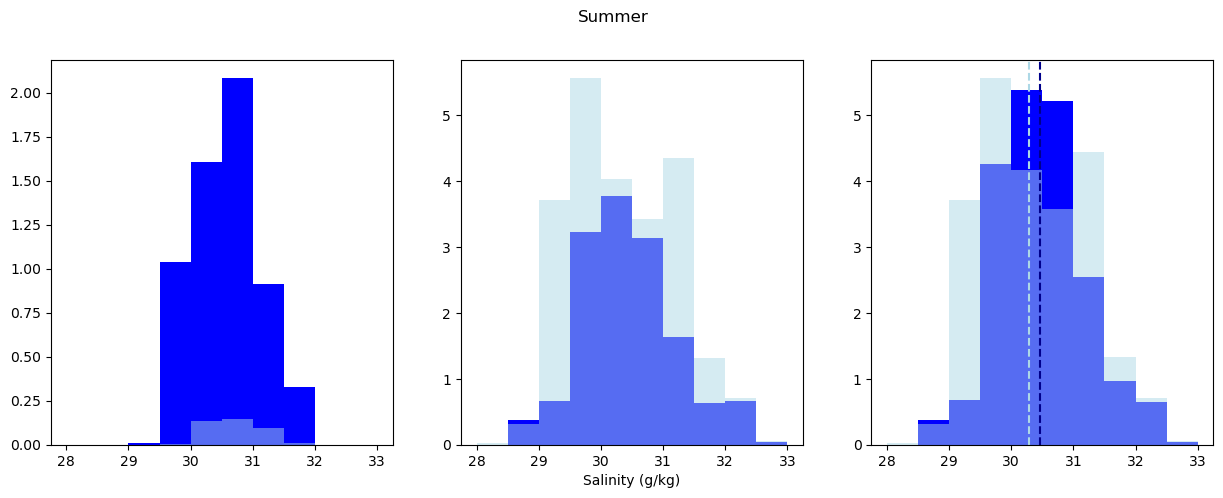

In [ ]:
sal_fpr_thruharo07 = np.append(prtoadm_haro07['final_salt'].values,prtovs_haro07['final_salt'].values)
sal_fpr_thruros07 = np.append(prtoadm_ros07['final_salt'].values,fpr_ros07['final_salt'].values)
transp_fpr_thruharo07 = np.append(prtoadm_haro07['final_transp'].values,prtovs_haro07['final_transp'].values)
transp_fpr_thruros07 = np.append(prtoadm_ros07['final_transp'].values,fpr_ros07['final_transp'].values)

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(prtoadm_ros07['final_salt'],bins=10,weights=prtoadm_ros07['final_transp']/23/1000,color='blue',label='',range=[28,33])
ax[0].hist(prtoadm_haro07['final_salt'],bins=10,weights=prtoadm_haro07['final_transp']/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax[1].hist(fpr_ros07['final_salt'],bins=10,weights=fpr_ros07['final_transp']/23/1000,color='blue',label='',range=[28,33])
ax[1].hist(prtovs_haro07['final_salt'],bins=10,weights=prtovs_haro07['final_transp']/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax[2].hist(sal_fpr_thruros07,bins=10,weights=transp_fpr_thruros07/23/1000,color='blue',label='',range=[28,33])
ax[2].hist(sal_fpr_thruharo07,bins=10,weights=transp_fpr_thruharo07/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax[2].axvline(sal_fpr_thruharo07.mean(),color='lightblue',ls='--')
ax[2].axvline(sal_fpr_thruros07.mean(),color='darkblue',ls='--')
fig.suptitle('Summer')
ax[1].set_xlabel('Salinity (g/kg)')

Add gulf and see what happens

Look @ winter

Text(0.5, 0, 'Salinity (g/kg)')

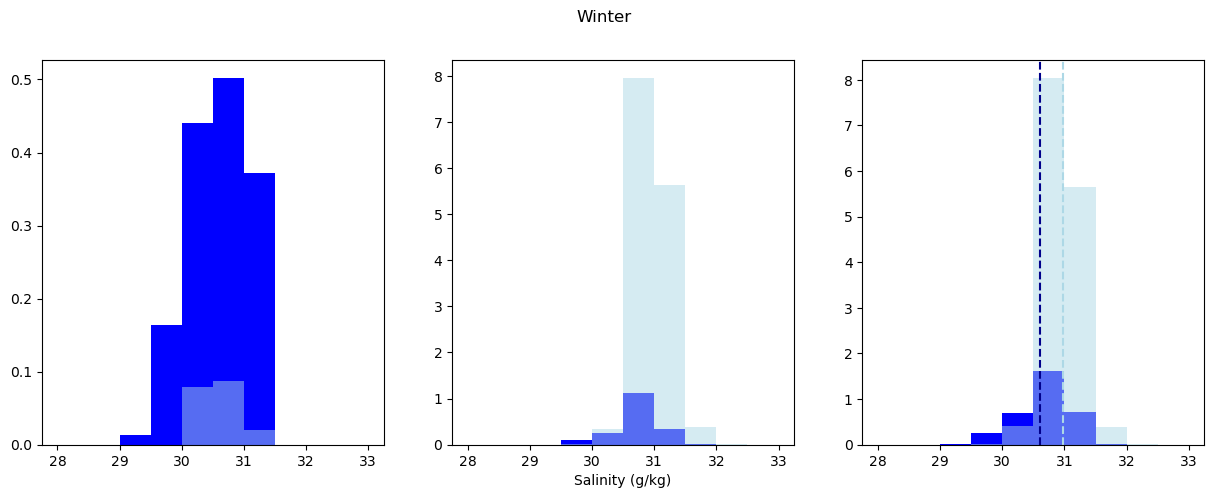

In [ ]:
sal_fpr_thruharo = np.append(prtoadm_haro['final_salt'].values,prtovs_haro['final_salt'].values)
sal_fpr_thruros = np.append(prtoadm_ros['final_salt'].values,fpr_ros['final_salt'].values)
transp_fpr_thruharo = np.append(prtoadm_haro['final_transp'].values,prtovs_haro['final_transp'].values)
transp_fpr_thruros = np.append(prtoadm_ros['final_transp'].values,fpr_ros['final_transp'].values)

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(prtoadm_ros['final_salt'],bins=10,weights=prtoadm_ros['final_transp']/23/1000,color='blue',label='',range=[28,33])
ax[0].hist(prtoadm_haro['final_salt'],bins=10,weights=prtoadm_haro['final_transp']/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax[1].hist(fpr_ros['final_salt'],bins=10,weights=fpr_ros['final_transp']/23/1000,color='blue',label='',range=[28,33])
ax[1].hist(prtovs_haro['final_salt'],bins=10,weights=prtovs_haro['final_transp']/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax[2].hist(sal_fpr_thruros,bins=10,weights=transp_fpr_thruros/23/1000,color='blue',label='',range=[28,33])
ax[2].hist(sal_fpr_thruharo,bins=10,weights=transp_fpr_thruharo/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax[2].axvline(sal_fpr_thruharo.mean(),color='lightblue',ls='--')
ax[2].axvline(sal_fpr_thruros.mean(),color='darkblue',ls='--')

fig.suptitle('Winter')
ax[1].set_xlabel('Salinity (g/kg)')

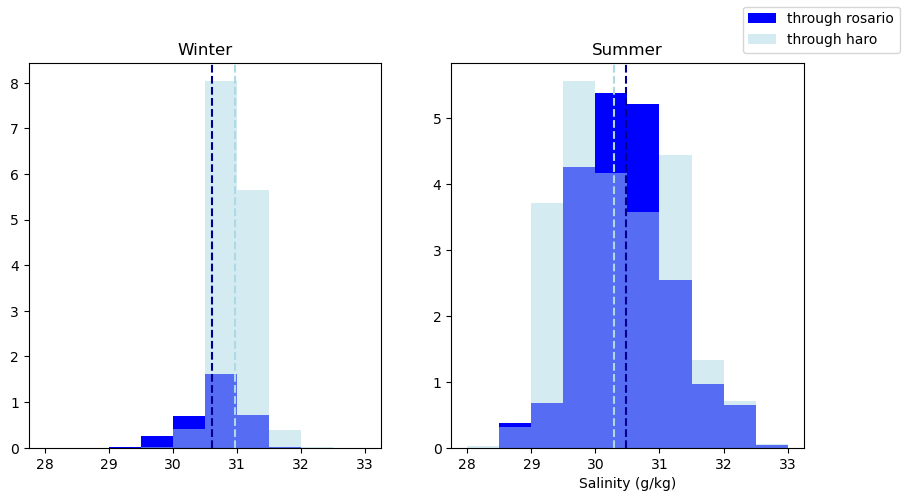

In [ ]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(10,5))

ax2.hist(sal_fpr_thruros07,bins=10,weights=transp_fpr_thruros07/23/1000,color='blue',label='through rosario',range=[28,33])
ax2.hist(sal_fpr_thruharo07,bins=10,weights=transp_fpr_thruharo07/23/1000,color='lightblue',label='through haro',alpha=0.5,range=[28,33])
ax1.hist(sal_fpr_thruros,bins=10,weights=transp_fpr_thruros/23/1000,color='blue',range=[28,33])
ax1.hist(sal_fpr_thruharo,bins=10,weights=transp_fpr_thruharo/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax1.axvline(sal_fpr_thruharo.mean(),color='lightblue',ls='--')
ax1.axvline(sal_fpr_thruros.mean(),color='darkblue',ls='--')
ax2.axvline(sal_fpr_thruharo07.mean(),color='lightblue',ls='--')
ax2.axvline(sal_fpr_thruros07.mean(),color='darkblue',ls='--')
ax2.set_title('Summer')
ax1.set_title('Winter')
ax2.set_xlabel('Salinity (g/kg)')
fig.legend()

Add gulf contribution

In [ ]:
gulftoadm_haro = get_secdata(datafgulf_haro,2)
gulftoadm_ros = get_secdata(datafgulf_ros,2)
gulftoadm_haro07 = get_secdata(datafgulf_haro07,2)
gulftoadm_ros07 = get_secdata(datafgulf_ros07,2)
gulftovs_ros = get_secdata(datafgulf_ros,4)
gulftovs_ros07 = get_secdata(datafgulf_ros07,4)
gulftoadm_haro['final_transp'].sum()/24,prtoadm_haro['final_transp'].sum()/24,gulftoadm_ros['final_transp'].sum()/24,gulftoadm_ros07['final_transp'].sum()/24,gulftovs_haro['final_transp'].sum()/24

(<xarray.DataArray 'final_transp' ()>
 array(65.88249268),
 <xarray.DataArray 'final_transp' ()>
 array(178.77824003),
 <xarray.DataArray 'final_transp' ()>
 array(107.04297978),
 <xarray.DataArray 'final_transp' ()>
 array(24.09069872),
 <xarray.DataArray 'final_transp' ()>
 array(5584.94218498))

The only really significant change is more from gulf to vs through Haro

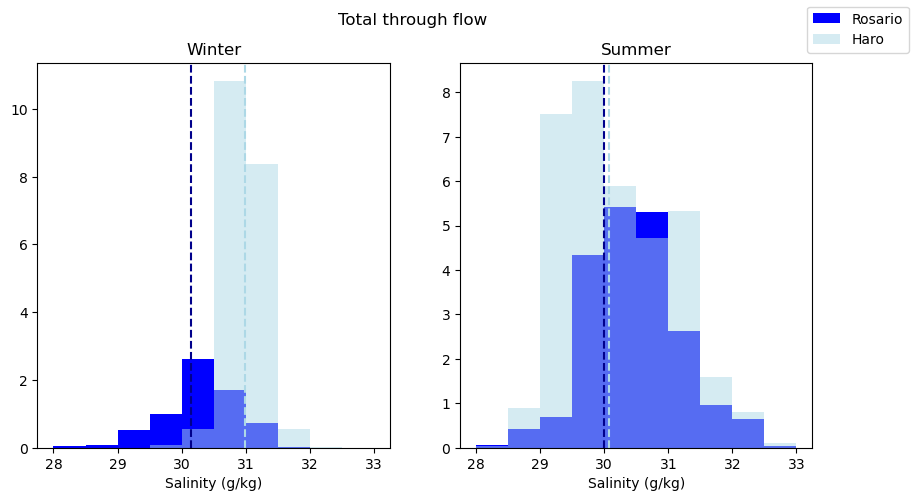

In [ ]:
sal_thruharo_int = np.append(sal_fpr_thruharo,gulftovs_haro['final_salt'].values)
sal_thruharo = np.append(sal_thruharo_int,gulftoadm_haro['final_salt'].values)
sal_thruros_int = np.append(sal_fpr_thruros,gulftovs_ros['final_salt'].values)
sal_thruros = np.append(sal_thruros_int,gulftoadm_ros['final_salt'].values)
sal_thruharo07_int = np.append(sal_fpr_thruharo07,gulftovs_haro07['final_salt'].values)
sal_thruharo07 = np.append(sal_thruharo07_int,gulftoadm_haro07['final_salt'].values)
sal_thruros07_int = np.append(sal_fpr_thruros07,gulftovs_ros07['final_salt'].values)
sal_thruros07 = np.append(sal_thruros07_int,gulftoadm_ros07['final_salt'].values)

transp_thruharo_int = np.append(transp_fpr_thruharo,gulftovs_haro['final_transp'].values)
transp_thruharo = np.append(transp_thruharo_int,gulftoadm_haro['final_transp'].values)
transp_thruros_int = np.append(transp_fpr_thruros,gulftovs_ros['final_transp'].values)
transp_thruros = np.append(transp_thruros_int,gulftoadm_ros['final_transp'].values)
transp_thruharo07_int = np.append(transp_fpr_thruharo07,gulftovs_haro07['final_transp'].values)
transp_thruharo07 = np.append(transp_thruharo07_int,gulftoadm_haro07['final_transp'].values)
transp_thruros07_int = np.append(transp_fpr_thruros07,gulftovs_ros07['final_transp'].values)
transp_thruros07 = np.append(transp_thruros07_int,gulftoadm_ros07['final_transp'].values)

fig,ax = plt.subplots(1,2,figsize=(10,5))

ax[0].hist(sal_thruros,bins=10,weights=transp_thruros/23/1000,color='blue',label='Rosario',range=[28,33])
ax[0].hist(sal_thruharo,bins=10,weights=transp_thruharo/23/1000,color='lightblue',alpha=0.5,label='Haro',range=[28,33])
ax[1].hist(sal_thruros07,bins=10,weights=transp_thruros07/23/1000,color='blue',label='',range=[28,33])
ax[1].hist(sal_thruharo07,bins=10,weights=transp_thruharo07/23/1000,color='lightblue',alpha=0.5,label='',range=[28,33])
ax[0].axvline(sal_thruharo.mean(),color='lightblue',ls='--')
ax[0].axvline(sal_thruros.mean(),color='darkblue',ls='--')
ax[1].axvline(sal_thruharo07.mean(),color='lightblue',ls='--')
ax[1].axvline(sal_thruros07.mean(),color='darkblue',ls='--')
ax[0].set_title('Winter')
ax[1].set_title('Summer')
ax[1].set_xlabel('Salinity (g/kg)')
ax[0].set_xlabel('Salinity (g/kg)')
fig.suptitle('Total through flow')
fig.legend()

In [ ]:
transp_thruharo07.sum()/23,transp_thruros07.sum()/23

(35164.71230798754, 21739.0148858611)

In [ ]:
transp_fpr_thruros.sum()/23,transp_fpr_thruros07.sum()/23

(3322.935753143953, 20162.01397447787)

#### Change in salinity from initial to final section

In [ ]:
initsal_fpr_thruharo = np.append(prtoadm_haro['init_salt'],prtovs_haro['init_salt'])
initsal_thruharo_int = np.append(initsal_fpr_thruharo,gulftovs_haro['init_salt'])
initsal_thruharo = np.append(initsal_thruharo_int,gulftoadm_haro['init_salt'])

initsal_fpr_thruharo07 = np.append(prtoadm_haro07['init_salt'],prtovs_haro07['init_salt'])
initsal_thruharo07_int = np.append(initsal_fpr_thruharo07,gulftovs_haro07['init_salt'])
initsal_thruharo07 = np.append(initsal_thruharo07_int,gulftoadm_haro07['init_salt'])

initsal_fpr_thruros = np.append(prtoadm_ros['init_salt'],fpr_ros['init_salt'])
initsal_thruros_int = np.append(initsal_fpr_thruros,gulftovs_ros['init_salt'])
initsal_thruros = np.append(initsal_thruros_int,gulftoadm_ros['init_salt'])

initsal_fpr_thruros07 = np.append(prtoadm_ros07['init_salt'],fpr_ros07['init_salt'])
initsal_thruros07_int = np.append(initsal_fpr_thruros07,gulftovs_ros07['init_salt'])
initsal_thruros07 = np.append(initsal_thruros07_int,gulftoadm_ros07['init_salt'])

initsal_fpr_thruharo = np.append(prtoadm_haro['init_salt'],prtovs_haro['init_salt'])
initsal_thruharo_int = np.append(initsal_fpr_thruharo,gulftovs_haro['init_salt'])
initsal_thruharo = np.append(initsal_thruharo_int,gulftoadm_haro['init_salt'])
# finallon_fpr_thruharo = np.append(prtoadm_haro['final_lon'],prtovs_haro['final_lon'])
# finallon_thruharo_int = np.append(finallon_fpr_thruharo,gulftovs_haro['final_lon'])
# finallon_thruharo = np.append(finallon_thruharo_int,gulftoadm_haro['final_lon'])

# finalz_fpr_thruharo = np.append(prtoadm_haro['final_lon'],prtovs_haro['final_z'])
# finalz_thruharo_int = np.append(finalz_fpr_thruharo,gulftovs_haro['final_z'])
# finalz_thruharo = np.append(finalz_thruharo_int,gulftoadm_haro['final_z'])



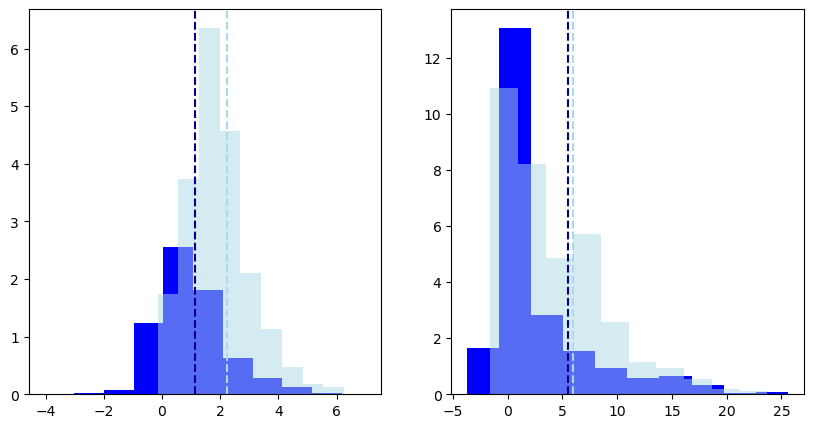

In [ ]:
deltasal_thruharo = (sal_thruharo - initsal_thruharo)
deltasal_thruros = (sal_thruros - initsal_thruros)
deltasal_thruharo07 = (sal_thruharo07 - initsal_thruharo07)
deltasal_thruros07 = (sal_thruros07 - initsal_thruros07)

fig,[ax,ax2] = plt.subplots(1,2,figsize=(10,5))

ax.hist(deltasal_thruros,bins=10,weights=transp_thruros/23/1000,color='blue',label='')
ax.hist(deltasal_thruharo,bins=10,weights=transp_thruharo/23/1000,color='lightblue',alpha=0.5,label='')
ax.axvline(deltasal_thruros.mean(),color='darkblue',ls='--')
ax.axvline(deltasal_thruharo.mean(),color='lightblue',ls='--')

ax2.hist(deltasal_thruros07,bins=10,weights=transp_thruros07/23/1000,color='blue',label='')
ax2.hist(deltasal_thruharo07,bins=10,weights=transp_thruharo07/23/1000,color='lightblue',alpha=0.5,label='')
ax2.axvline(deltasal_thruros07.mean(),color='darkblue',ls='--')
ax2.axvline(deltasal_thruharo07.mean(),color='lightblue',ls='--')

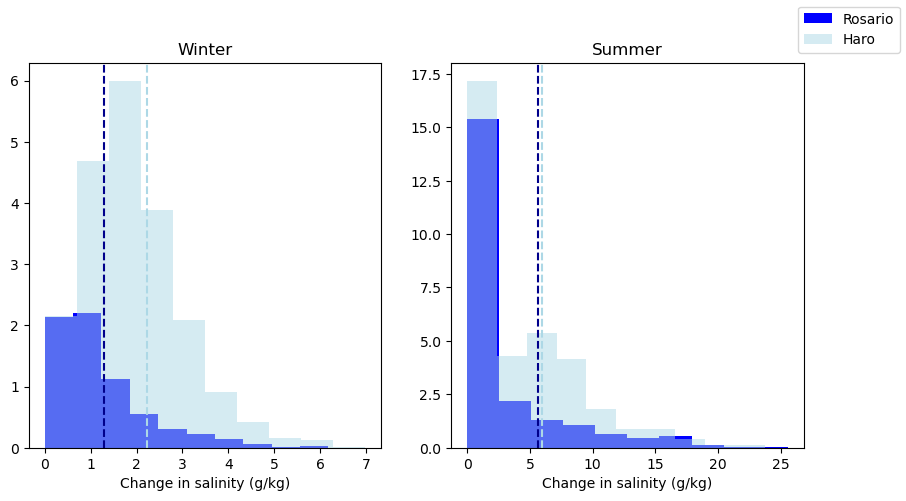

In [ ]:
deltasal_thruharo = np.abs(sal_thruharo - initsal_thruharo)
deltasal_thruros = np.abs(sal_thruros - initsal_thruros)
deltasal_thruharo07 = np.abs(sal_thruharo07 - initsal_thruharo07)
deltasal_thruros07 = np.abs(sal_thruros07 - initsal_thruros07)

fig,[ax,ax2] = plt.subplots(1,2,figsize=(10,5))

ax.hist(deltasal_thruros,bins=10,weights=transp_thruros/23/1000,color='blue',label='Rosario')
ax.hist(deltasal_thruharo,bins=10,weights=transp_thruharo/23/1000,color='lightblue',alpha=0.5,label='Haro')
ax.axvline(deltasal_thruros.mean(),color='darkblue',ls='--')
ax.axvline(deltasal_thruharo.mean(),color='lightblue',ls='--')
ax.set_title('Winter')
ax.set_xlabel('Change in salinity (g/kg)')

ax2.hist(deltasal_thruros07,bins=10,weights=transp_thruros07/23/1000,color='blue',label='')
ax2.hist(deltasal_thruharo07,bins=10,weights=transp_thruharo07/23/1000,color='lightblue',alpha=0.5,label='')
ax2.axvline(deltasal_thruros07.mean(),color='darkblue',ls='--')
ax2.axvline(deltasal_thruharo07.mean(),color='lightblue',ls='--')
ax2.set_xlabel('Change in salinity (g/kg)')
ax2.set_title('Summer')
fig.legend()